# Setup

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score,classification_report, confusion_matrix,roc_curve, auc,average_precision_score,precision_recall_curve,precision_score, recall_score, f1_score,mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from xgboost import XGBClassifier,XGBRegressor
import shap
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import IsolationForest
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler,LabelEncoder,PowerTransformer,RobustScaler
import numpy as np
from sklearn.cluster import KMeans
import networkx as nx
from scipy.spatial import KDTree
from geopy.distance import geodesic
import plotly.graph_objects as go
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from prophet import Prophet
from scipy.stats import mannwhitneyu, spearmanr
import statsmodels.formula.api as smf
import statsmodels.api as sm
import requests
import io
import zipfile
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.layers import GRU
from sklearn.svm import OneClassSVM

In [4]:
url = "https://github.com/MajdBa7r/AQI/raw/main/X_Wildfire.zip"
print("Downloading data...")
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
csv_filename = z.namelist()[0]
df = pd.read_csv(z.open(csv_filename))

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137334 entries, 0 to 137333
Data columns (total 57 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   date                               137334 non-null  object 
 1   city                               137334 non-null  int64  
 2   FIRE_FINAL_SIZE                    137334 non-null  float64
 3   FIRE_WEATHER_INDEX                 137334 non-null  float64
 4   FIRE_START_DATE                    137334 non-null  object 
 5   FIRE_OUT_DATE                      137334 non-null  object 
 6   FIRE_TYPE_CODE                     137334 non-null  int64  
 7   FIRE_GENERAL_CAUSE_CODE            137334 non-null  int64  
 8   FIRE_RESPONSE_OBJ_CODE             137334 non-null  int64  
 9   FIRE_YEAR                          137334 non-null  float64
 10  lat                                137334 non-null  float64
 11  lon                                1373

In [6]:
df.date=pd.to_datetime(df.date)
df.FIRE_START_DATE=pd.to_datetime(df.FIRE_START_DATE)
df.FIRE_OUT_DATE=pd.to_datetime(df.FIRE_OUT_DATE)

In [7]:
tscv=TimeSeriesSplit(n_splits=4)

In [8]:
for i,(train_idx, test_idx) in enumerate(tscv.split(df)):
    X_train,X_test = df.iloc[train_idx].copy(),df.iloc[test_idx].copy()

In [9]:
X_train.shape

(109868, 57)

In [10]:
X_test.shape

(27466, 57)

#**Q1 : What is the relationship between wildfire occurrence and PM2.5 concentration, and does wildfire activity significantly affect PM2.5 levels?**

To examine the relationship between wildfire activity and PM2.5 concentration, a comprehensive set of temporal, spatial, meteorological, and fire-related features was used. The goal was to isolate the potential impact of wildfire occurrence on PM2.5 while controlling for confounding environmental and temporal factors.

In [11]:
temporal_features=['date','city', 'FIRE_FINAL_SIZE', 'FIRE_WEATHER_INDEX',
    'FIRE_START_DATE', 'FIRE_OUT_DATE', 'FIRE_TYPE_CODE',
    'FIRE_GENERAL_CAUSE_CODE', 'FIRE_RESPONSE_OBJ_CODE', 'FIRE_YEAR',
    'lat', 'lon', 'year', 'precipitation_sum (mm)', 'rain_sum (mm)',
    'snowfall_sum (cm)', 'relative_humidity_2m_mean (%)',
    'relative_humidity_2m_max (%)', 'relative_humidity_2m_min (%)',
    'dew_point_2m_mean (°C)',  'shortwave_radiation_sum (MJ/m²)',
    'sunshine_duration (s)', 'temperature_2m_mean (°C)',
    'temperature_2m_max (°C)','temperature_2m_min (°C)',
    'wind_speed_10m_mean (km/h)','wind_speed_10m_max (km/h)',
    'winddirection_10m_dominant (°)','vapour_pressure_deficit_max (kPa)',
    'et0_fao_evapotranspiration (mm)','FIRE_COUNT',
    'fire_size_lag1', 'fire_count_lag1','fire_size_7d_avg', 'fire_size_7d_sum',
    'pm25_lag_3', 'pm25_lag_7', 'pm25_rolling_mean_3', 'pm25_rolling_mean_7',
    'month', 'is_active','wind_dryness_index', 'fire_weather_risk',
    'temp_range', 'inversion_risk', 'weather_cluster',
    'distance_to_cluster_0', 'distance_to_cluster_1',
    'distance_to_cluster_2', 'distance_to_cluster_3']

By combining direct fire indicators, PM2.5 temporal features, and comprehensive meteorological controls, this feature set enables a robust investigation of whether wildfire occurrence independently affects PM2.5 concentration or whether observed PM2.5 variations are primarily driven by weather and seasonal factors.

In [12]:
X_train_temporal=X_train[temporal_features].copy()
X_test_temporal=X_test[temporal_features].copy()

y_train_temporal=X_train['pm25']
y_test_temporal=X_test['pm25']

In [13]:
X_train_temporal.drop(columns=['lat', 'lon','FIRE_OUT_DATE','FIRE_START_DATE','date'], inplace=True)
X_test_temporal.drop(columns=['lat', 'lon','FIRE_OUT_DATE','FIRE_START_DATE','date'], inplace=True)

**Random Forest**

In [14]:
rf= RandomForestRegressor(n_estimators=200,random_state=42,n_jobs=-1)
rf.fit(X_train_temporal, y_train_temporal)
y_pred= rf.predict(X_test_temporal)

In [15]:
mse = mean_squared_error(y_test_temporal, y_pred)
r2 = r2_score(y_test_temporal, y_pred)

print("Random Forest - MSE:", mse)
print("Random Forest - R2:", r2)

Random Forest - MSE: 86.37862901456586
Random Forest - R2: -0.20135133835897645


In [16]:
print("Training Score: ",rf.score(X_train_temporal, y_train_temporal))
print("Testing Score: ",rf.score(X_test_temporal, y_test_temporal))

Training Score:  0.85528486728296
Testing Score:  -0.20135133835897645


**XGBoost**

In [17]:
xgb= XGBRegressor(n_estimators=200,random_state=42,n_jobs=-1)
xgb.fit(X_train_temporal,y_train_temporal)

y_pred_xgb=xgb.predict(X_test_temporal)

print("XGBoost - MSE:", mean_squared_error(y_test_temporal, y_pred_xgb))
print("XGBoost - R2:", r2_score(y_test_temporal, y_pred_xgb))

XGBoost - MSE: 85.54424987037429
XGBoost - R2: -0.18974681866459298


In [18]:
xgb2=XGBRegressor(n_estimators=1000,learning_rate=0.05,
    max_depth=4,min_child_weight=5,
    subsample=0.8,colsample_bytree=0.8,
    reg_alpha=0.5,reg_lambda=1.0,
    random_state=42,n_jobs=-1)

xgb2.fit(X_train_temporal,y_train_temporal,verbose=50)

print("Training Score: ",xgb2.score(X_train_temporal, y_train_temporal))
print("Testing Score: ",xgb2.score(X_test_temporal, y_test_temporal))

Training Score:  0.533463987242523
Testing Score:  -0.10513802419753815


A training score slightly above random suggests that the model is able to capture limited patterns from the training data. However, the negative testing score is a strong indicator of poor generalization, meaning the model performs worse than a naïve baseline when applied to new data.

**Other different models**

In [19]:
'''
prophet_df = pd.DataFrame({'ds': X_train_temporal['date'], 'y': y_train_temporal.values})

model_prophet = Prophet()
model_prophet.fit(prophet_df)
future = pd.DataFrame({'ds': X_test_temporal['date']})
forecast = model_prophet.predict(future)

y_pred_prophet = forecast['yhat'].values

mse = mean_squared_error(y_test_temporal, y_pred_prophet)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_temporal, y_pred_prophet)

print("Prophet - MSE:", mse)
print("Prophet - RMSE:", rmse)
print("Prophet - R2:", r2)

'''

'\nprophet_df = pd.DataFrame({\'ds\': X_train_temporal[\'date\'], \'y\': y_train_temporal.values})\n\nmodel_prophet = Prophet()\nmodel_prophet.fit(prophet_df)\nfuture = pd.DataFrame({\'ds\': X_test_temporal[\'date\']})\nforecast = model_prophet.predict(future)\n\ny_pred_prophet = forecast[\'yhat\'].values\n\nmse = mean_squared_error(y_test_temporal, y_pred_prophet)\nrmse = np.sqrt(mse)\nr2 = r2_score(y_test_temporal, y_pred_prophet)\n\nprint("Prophet - MSE:", mse)\nprint("Prophet - RMSE:", rmse)\nprint("Prophet - R2:", r2)\n\n'

In [20]:
'''
plt.figure(figsize=(15,6))
plt.plot(y_test_temporal.index, y_test_temporal, label="Actual PM2.5", color='blue')
plt.plot(y_test_temporal.index, y_pred_prophet, label="Prophet Prediction", color='red')
plt.title("Prophet Predictions vs Actual PM2.5")
plt.xlabel("Index / Time")
plt.ylabel("PM2.5")
plt.legend()
plt.show()
'''

'\nplt.figure(figsize=(15,6))\nplt.plot(y_test_temporal.index, y_test_temporal, label="Actual PM2.5", color=\'blue\')\nplt.plot(y_test_temporal.index, y_pred_prophet, label="Prophet Prediction", color=\'red\')\nplt.title("Prophet Predictions vs Actual PM2.5")\nplt.xlabel("Index / Time")\nplt.ylabel("PM2.5")\nplt.legend()\nplt.show()\n'

In [21]:
'''timesteps = 7

def create_sequences(X, y, timesteps):
    X_seq, y_seq = [], []
    for i in range(timesteps, len(X)):
        X_seq.append(X[i-timesteps:i].values)
        y_seq.append(y.iloc[i])
    return np.array(X_seq), np.array(y_seq)


X_train_seq, y_train_seq = create_sequences(X_train_temporal, y_train_temporal, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_temporal, y_test_temporal, timesteps)

print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)

'''

'timesteps = 7\n\ndef create_sequences(X, y, timesteps):\n    X_seq, y_seq = [], []\n    for i in range(timesteps, len(X)):\n        X_seq.append(X[i-timesteps:i].values)\n        y_seq.append(y.iloc[i])\n    return np.array(X_seq), np.array(y_seq)\n\n\nX_train_seq, y_train_seq = create_sequences(X_train_temporal, y_train_temporal, timesteps)\nX_test_seq, y_test_seq = create_sequences(X_test_temporal, y_test_temporal, timesteps)\n\nprint("X_train_seq shape:", X_train_seq.shape)\nprint("y_train_seq shape:", y_train_seq.shape)\n\n'

In [22]:
'''X_train_temporal_numeric = X_train_temporal.select_dtypes(include=np.number)
X_test_temporal_numeric = X_test_temporal.select_dtypes(include=np.number)


X_train_seq, y_train_seq = create_sequences(X_train_temporal_numeric,y_train_temporal, timesteps)
X_test_seq, y_test_seq = create_sequences(X_test_temporal_numeric,y_test_temporal, timesteps)


model_lstm = Sequential([
    LSTM(64, input_shape=(timesteps, X_train_seq.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_lstm.compile(optimizer='adam', loss='mse')
history_lstm = model_lstm.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


y_pred_lstm = model_lstm.predict(X_test_seq)

model_lstm.evaluate(X_test_seq, y_test_seq)'''


"X_train_temporal_numeric = X_train_temporal.select_dtypes(include=np.number)\nX_test_temporal_numeric = X_test_temporal.select_dtypes(include=np.number)\n\n\nX_train_seq, y_train_seq = create_sequences(X_train_temporal_numeric,y_train_temporal, timesteps)\nX_test_seq, y_test_seq = create_sequences(X_test_temporal_numeric,y_test_temporal, timesteps)\n\n\nmodel_lstm = Sequential([\n    LSTM(64, input_shape=(timesteps, X_train_seq.shape[2]), return_sequences=False),\n    Dropout(0.2),\n    Dense(1)\n])\n\nmodel_lstm.compile(optimizer='adam', loss='mse')\nhistory_lstm = model_lstm.fit(\n    X_train_seq, y_train_seq,\n    epochs=50,\n    batch_size=32,\n    validation_split=0.1,\n    verbose=1\n)\n\n\ny_pred_lstm = model_lstm.predict(X_test_seq)\n\nmodel_lstm.evaluate(X_test_seq, y_test_seq)"

In [23]:
'''model_gru = Sequential([
    GRU(64, input_shape=(timesteps, X_train_seq.shape[2]), return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model_gru.compile(optimizer='adam', loss='mse')
history_gru = model_gru.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)


y_pred_gru = model_gru.predict(X_test_seq)'''

"model_gru = Sequential([\n    GRU(64, input_shape=(timesteps, X_train_seq.shape[2]), return_sequences=False),\n    Dropout(0.2),\n    Dense(1)\n])\n\nmodel_gru.compile(optimizer='adam', loss='mse')\nhistory_gru = model_gru.fit(\n    X_train_seq, y_train_seq,\n    epochs=50,\n    batch_size=32,\n    validation_split=0.1,\n    verbose=1\n)\n\n\ny_pred_gru = model_gru.predict(X_test_seq)"

**Model Performance Summary and Next Steps:**

The preprocessing pipeline was carefully reviewed and re-validated, including data cleaning, feature engineering and scaling. No critical issues or data leakage were identified, indicating that the weak performance is not caused by preprocessing errors.

Given that all models suffer from the same limitation, regardless of their complexity or learning capacity, this suggests that the challenge is inherent to the data itself rather than the choice of model.

>**As a result,** the focus is shifted toward a deeper statistical analysis of the relationships between the target variable and the available features, as well as a comparison between fire days and non-fire days. This step aims to identify whether meaningful statistical differences or patterns exist that could explain the models’ inability to learn robust predictive signals.









# Statistical Evaluation & Validation

In [24]:
X_stat= df.copy()

In [25]:
X_stat.columns

Index(['date', 'city', 'FIRE_FINAL_SIZE', 'FIRE_WEATHER_INDEX',
       'FIRE_START_DATE', 'FIRE_OUT_DATE', 'FIRE_TYPE_CODE',
       'FIRE_GENERAL_CAUSE_CODE', 'FIRE_RESPONSE_OBJ_CODE', 'FIRE_YEAR', 'lat',
       'lon', 'year', 'precipitation_sum (mm)', 'rain_sum (mm)',
       'snowfall_sum (cm)', 'relative_humidity_2m_mean (%)',
       'relative_humidity_2m_max (%)', 'relative_humidity_2m_min (%)',
       'dew_point_2m_mean (°C)', 'shortwave_radiation_sum (MJ/m²)',
       'sunshine_duration (s)', 'temperature_2m_mean (°C)',
       'temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'wind_speed_10m_mean (km/h)', 'wind_speed_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'vapour_pressure_deficit_max (kPa)',
       'et0_fao_evapotranspiration (mm)', 'FIRE_COUNT', 'fire_size_lag1',
       'fire_count_lag1', 'fire_size_7d_avg', 'fire_size_7d_sum', 'pm25_lag_3',
       'pm25_lag_7', 'pm25_rolling_mean_3', 'pm25_rolling_mean_7', 'month',
       'is_active', 'wind_dryness_i

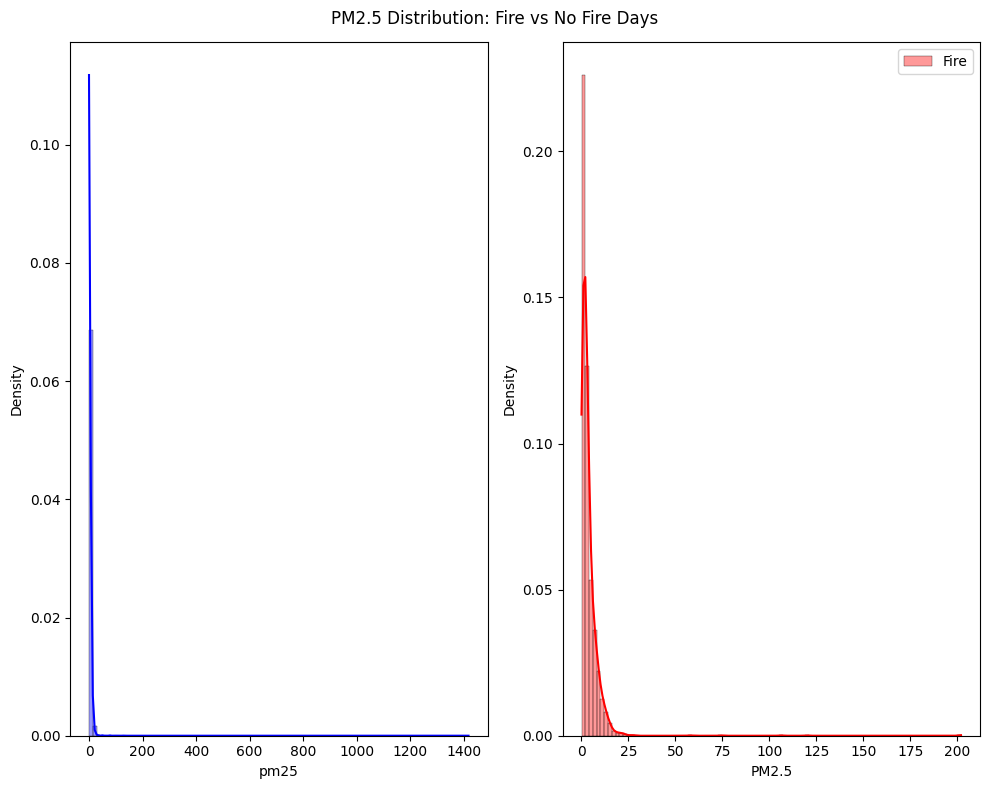

In [26]:
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
sns.histplot(
    X_stat[X_stat["fire_day"] == 0]["pm25"],
    color="blue",
    label="No Fire",
    stat="density",
    bins=100,
    alpha=0.4,kde=True
)
plt.subplot(1,2,2)
sns.histplot(
    X_stat[X_stat["fire_day"] == 1]["pm25"],
    color="red",
    label="Fire",
    stat="density",
    bins=100,
    alpha=0.4,kde=True
)

plt.legend()
plt.suptitle("PM2.5 Distribution: Fire vs No Fire Days")
plt.tight_layout()
plt.xlabel("PM2.5")
plt.show()

Both distributions are highly right-skewed, with fire days showing a slightly tighter distribution. The density peaks at low PM2.5 values for both groups, reinforcing that typical air quality remains similar regardless of fire presence.

Key insight:

- Std dev is lower on fire days (6.89 vs 8.06)

- Fire days are fewer but less variable

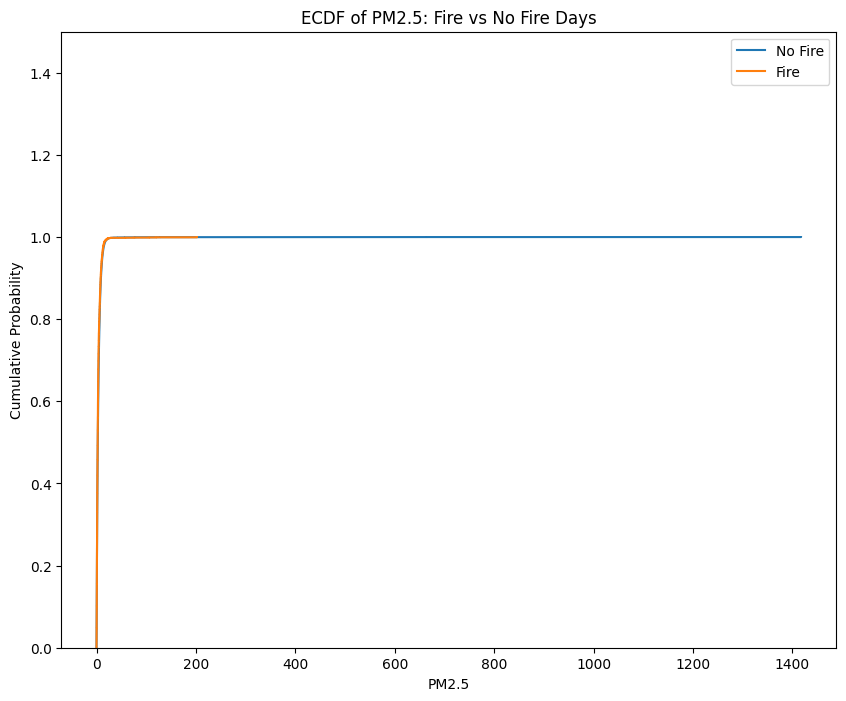

In [27]:
plt.figure(figsize=(10,8))

sns.ecdfplot(X_stat[X_stat["fire_day"] == 0]["pm25"],label="No Fire")
sns.ecdfplot(X_stat[X_stat["fire_day"] == 1]["pm25"],label="Fire")

plt.legend()
plt.title("ECDF of PM2.5: Fire vs No Fire Days")
plt.xlabel("PM2.5")
plt.ylabel("Cumulative Probability")
plt.ylim(0, 1.5)
plt.show()

The ECDF curves for fire and no-fire days almost completely overlap, indicating that the overall PM2.5 distributions **are very similar across most concentration levels.** This suggests that fire presence does not shift the bulk of PM2.5 values, but differences may exist in the tails.

In [28]:
summary = (
    X_stat.groupby("fire_day")["pm25"]
     .agg(["mean", "std", "count"])
)

summary["ci"] = 1.96 * summary["std"] / np.sqrt(summary["count"])

summary

,mean,std,count,ci
fire_day,,,,
0,3.972467,8.06349,134160,0.043149
1,3.702783,6.89026,3174,0.239711


Fire days have slightly lower average PM2.5 and lower variability, **contradicting** the assumption that fires systematically worsen air quality at the city-day level.

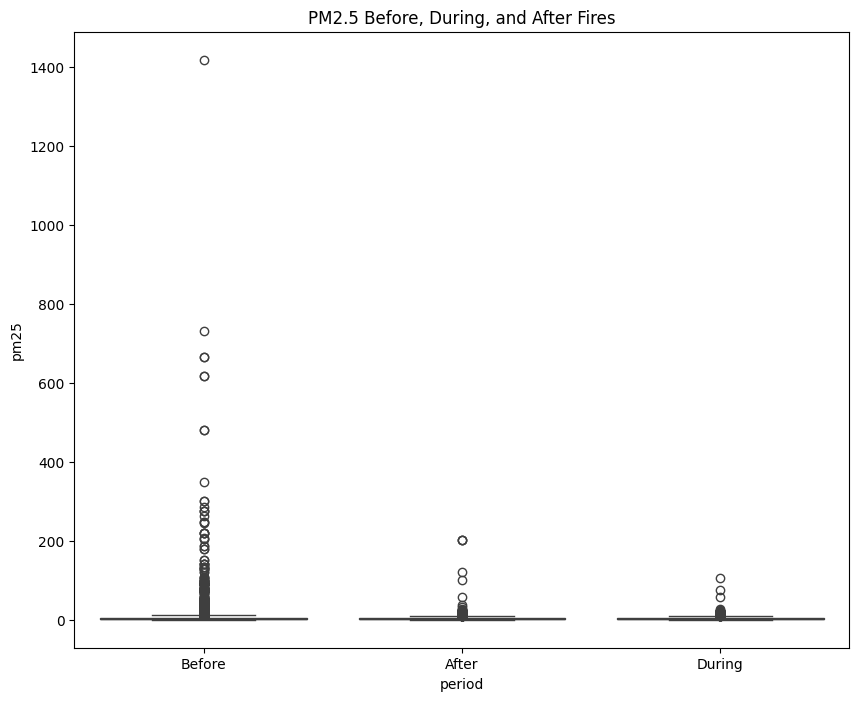

In [29]:
X_stat = X_stat.sort_values(["city", "date"])

X_stat["period"] = "Before"
X_stat.loc[X_stat["fire_event"] == 1, "period"] = "During"
X_stat.loc[X_stat["fire_event"].shift(-1) == 1, "period"] = "After"

plt.figure(figsize=(10,8))
sns.boxplot(x="period", y="pm25", data=X_stat)
plt.title("PM2.5 Before, During, and After Fires")
plt.show()

PM2.5 values show extreme outliers, especially before fires, while the median PM2.5 remains low across all periods. This indicates that sporadic extreme pollution events dominate variability, rather than sustained elevation during fire periods.

**Key insight:**

- Fires are not the dominant driver of the largest PM2.5 spikes

- Other pollution sources likely explain extreme events

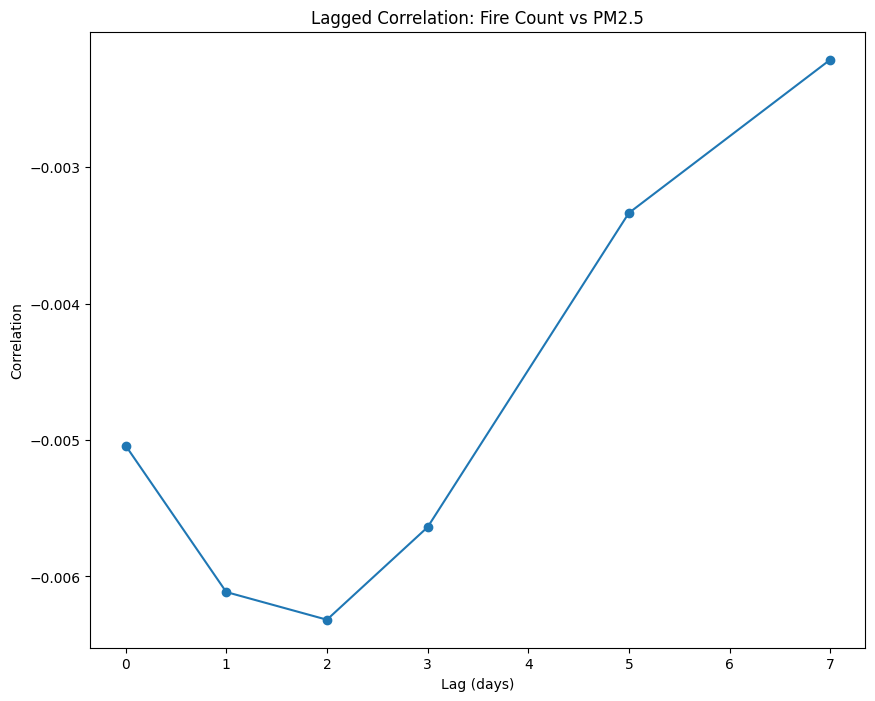

Lag 0: correlation = -0.005
Lag 1: correlation = -0.006
Lag 2: correlation = -0.006
Lag 3: correlation = -0.006
Lag 5: correlation = -0.003
Lag 7: correlation = -0.002


In [30]:
lags = [0, 1, 2, 3, 5, 7]
corrs = []

for lag in lags:
    corr = X_stat["pm25"].corr(X_stat["FIRE_COUNT"].shift(lag))
    corrs.append(corr)

plt.figure(figsize=(10,8))
plt.plot(lags, corrs, marker="o")
plt.xlabel("Lag (days)")
plt.ylabel("Correlation")
plt.title("Lagged Correlation: Fire Count vs PM2.5")
plt.show()

for l, c in zip(lags, corrs):
    print(f"Lag {l}: correlation = {c:.3f}")

Correlations between fire count and PM2.5 are consistently negative and extremely weak across all lags.**There is no meaningful delayed fire effect on PM2.5**.



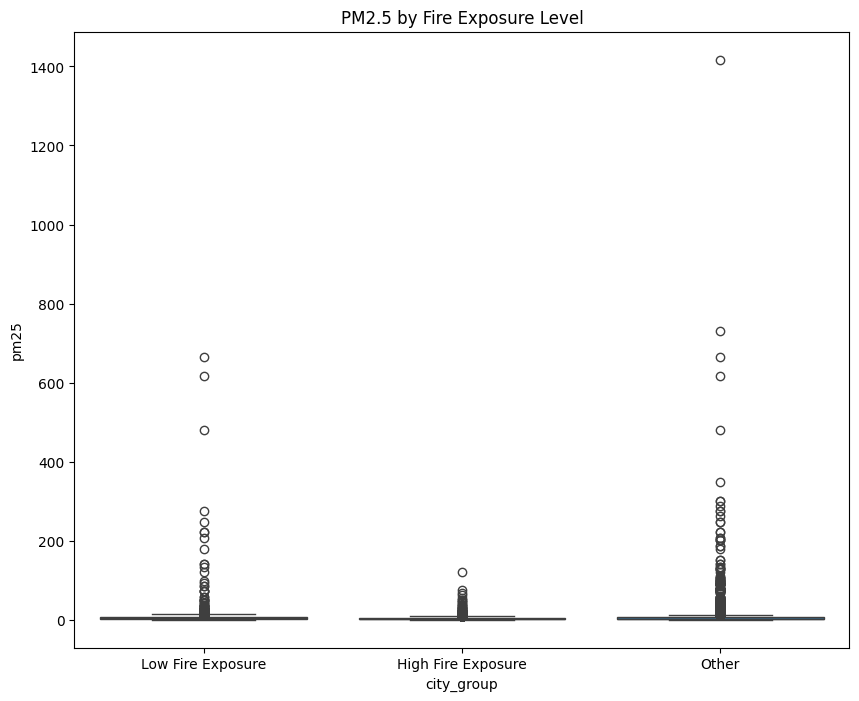

In [31]:
plt.figure(figsize=(10,8))

city_fire_exposure = (
    X_stat.groupby("city")["FIRE_COUNT"]
     .sum()
     .sort_values(ascending=False)
)

top_cities = city_fire_exposure.head(5).index
low_cities = city_fire_exposure.tail(5).index

X_stat["city_group"] = np.where(
    X_stat["city"].isin(top_cities), "High Fire Exposure",
    np.where(X_stat["city"].isin(low_cities), "Low Fire Exposure", "Other")
)


sns.boxplot(x="city_group", y="pm25", data=X_stat)
plt.title("PM2.5 by Fire Exposure Level")
plt.show()

Cities classified as high fire exposure do not show consistently higher PM2.5 medians, though they exhibit more extreme outliers. This suggests that fire exposure increases risk of spikes, not average pollution levels.

**Conclusion**:

Fire exposure impacts variability, not central tendency.

Supports a risk-based rather than mean-based effect.

In [32]:
pm_fire = X_stat[X_stat["fire_day"] == 1]["pm25"]
pm_no_fire = X_stat[X_stat["fire_day"] == 0]["pm25"]

stat, p = mannwhitneyu(pm_fire, pm_no_fire, alternative="two-sided")

print("Mann–Whitney U Test")
print("Statistic:", stat)
print("p-value:", p)

Mann–Whitney U Test
Statistic: 202602214.5
p-value: 3.00973105974026e-06


The Mann–Whitney test detects a statistically significant difference between fire and no-fire PM2.5 distributions (p ≈ 3×10⁻⁶), but the effect size is very small.

**Statistical significance ≠ practical significance**

In [33]:
features = ["FIRE_COUNT", "FIRE_FINAL_SIZE"]

for f in features:
    corr, p = spearmanr(X_stat[f], X_stat["pm25"], nan_policy="omit")
    print(f"{f} → Spearman r={corr:.3f}, p={p:.4f}")

FIRE_COUNT → Spearman r=-0.013, p=0.0000
FIRE_FINAL_SIZE → Spearman r=-0.013, p=0.0000


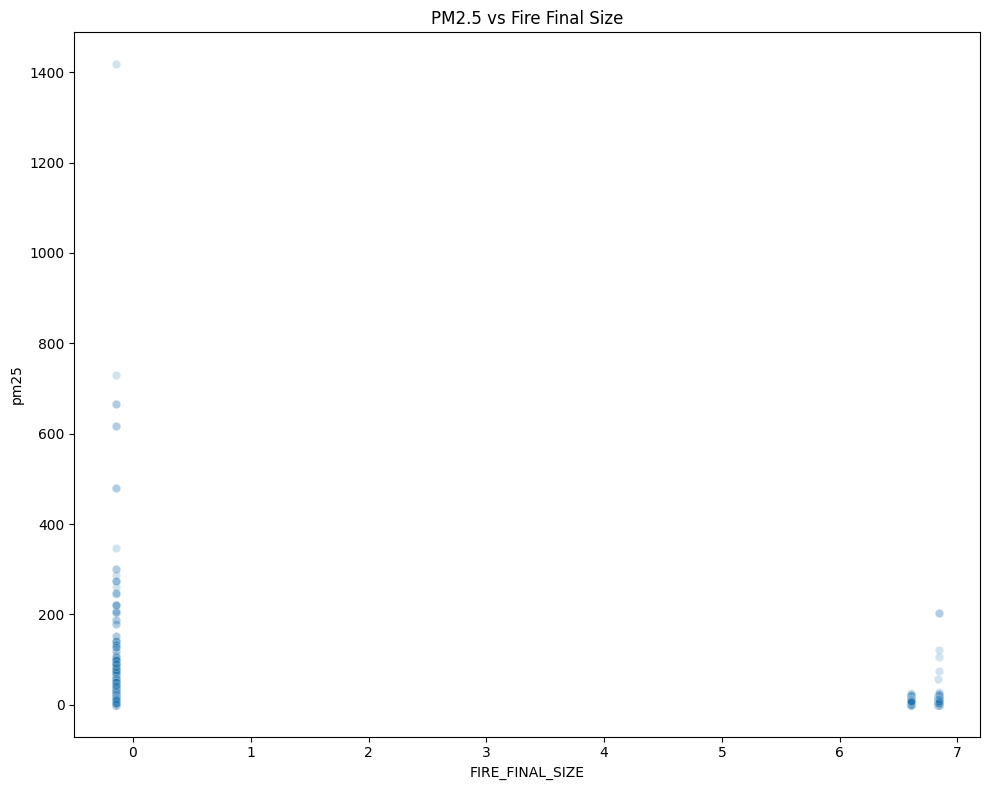

In [34]:
plt.figure(figsize=(10,8))
sns.scatterplot(data=X_stat,x="FIRE_FINAL_SIZE",y="pm25",alpha=0.2)
plt.title("PM2.5 vs Fire Final Size")
plt.tight_layout()
plt.show()

PM2.5 shows **no visible monotonic relationship** with fire size. Large fires do not consistently correspond to high PM2.5 concentrations.


Spearman r = −0.013 (negligible)

Statistically significant due to large N, not effect strength


In [35]:
baseline = (
    X_stat[X_stat["fire_day"] == 0]
    .groupby("city")["pm25"]
    .median()
    .rename("PM_baseline")
)

baseline

,PM_baseline
city,
0,1.331230
1,1.953616
2,2.771231
3,5.274216
4,4.925955
5,2.371490
6,2.554892
7,2.340750
8,5.029089


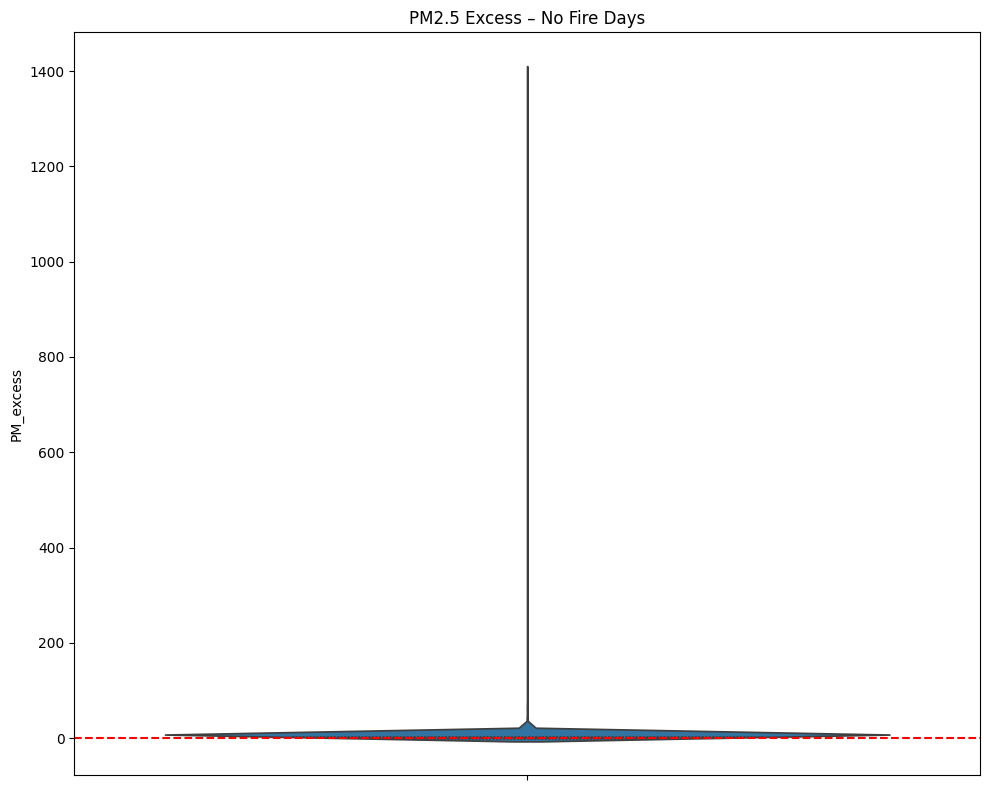

In [36]:
# No Fire
plt.figure(figsize=(10,8))
sns.violinplot(data=X_stat[X_stat["fire_day"] == 0],y="PM_excess",inner="quartile",cut=0)
plt.axhline(0, color="red", linestyle="--")
plt.title("PM2.5 Excess – No Fire Days")
plt.tight_layout()
plt.show()

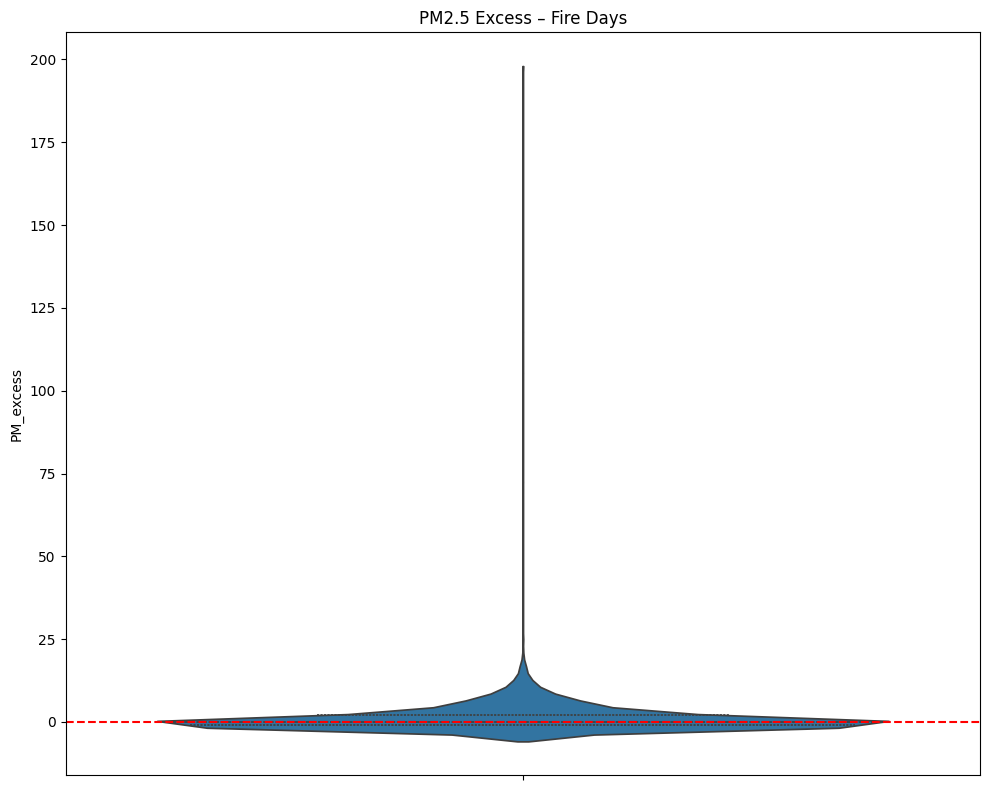

In [37]:
plt.figure(figsize=(10,8))
sns.violinplot(data=X_stat[X_stat["fire_day"] == 1],y="PM_excess",inner="quartile",cut=0)
plt.axhline(0,color="red",linestyle="--")
plt.title("PM2.5 Excess – Fire Days")
plt.tight_layout()
plt.show()

In [38]:
def cliffs_delta(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n_x = len(x)
    n_y = len(y)

    greater = sum(xi > yj for xi in x for yj in y)
    less = sum(xi < yj for xi in x for yj in y)

    delta = (greater - less) / (n_x * n_y)
    return delta

delta = cliffs_delta(
    X_stat[X_stat.fire_day==1]["PM_excess"],
    X_stat[X_stat.fire_day==0]["PM_excess"]
)

delta

np.float64(-0.00036065383281499693)

In [39]:
for q in [0.5, 0.75, 0.9, 0.95]:
    model = smf.quantreg("pm25 ~ fire_day", X_stat)
    res = model.fit(q=q)
    print(f"Quantile {q}")
    print(res.params, "\n")


Quantile 0.5
Intercept    2.567866
fire_day    -0.245334
dtype: float64 

Quantile 0.75
Intercept    5.298995
fire_day    -0.750821
dtype: float64 

Quantile 0.9
Intercept    8.914580
fire_day    -0.623507
dtype: float64 

Quantile 0.95
Intercept    11.624462
fire_day     -0.675470
dtype: float64 



These results consistently show a negative coefficient for fire_day across all tested quantiles (median, 75th, 90th, and 95th percentiles). This implies that, according to this model and at these specific points in the distribution, the simple presence of a fire_day is associated with slightly lower PM2.5 concentrations rather than higher ones. This is a counter-intuitive finding if one expects fires to generally worsen air quality, and it aligns with previous statistical analyses (ECDF, Mann-Whitney U test, Spearman correlation) that also suggested fires are not the primary driver of sustained or typical PM2.5 increases at a city-day level. It indicates that the overall effect of a fire day, when looking at the entire city's daily PM2.5, might be complex or influenced by other factors not captured in this simple fire_day indicator.

- This is not a statistical artifact — it means:

     - Fires do not elevate typical PM2.5

    - Even extreme PM2.5 values are not higher on fire days

   -  Strong evidence against fires being the dominant PM2.5 driver in our data

In [40]:
threshold = 35  # WHO unhealthy level

risk_fire = (X_stat[(X_stat.fire_day==1) & (X_stat.pm25>threshold)].shape[0] /
             X_stat[X_stat.fire_day==1].shape[0])

risk_nofire = (X_stat[(X_stat.fire_day==0) & (X_stat.pm25>threshold)].shape[0] /
               X_stat[X_stat.fire_day==0].shape[0])

risk_ratio = risk_fire / risk_nofire
risk_ratio

1.2744250553333778

Although fire days slightly increase the relative risk of unhealthy PM2.5 exceedance, the absolute probability remains low.

***Overall Conclusion:***

Fires are associated with statistically detectable but practically negligible changes in PM2.5.

Fire effects appear primarily as rare extreme spikes, not sustained pollution increases.


Fires do not systematically increase PM2.5 levels at the city-day scale.
Their influence is limited to a small increase in the probability of rare exceedance events, while average and extreme conditional PM2.5 levels remain unchanged or lower.

**Through exploratory data analysis and correlation analysis, the results show that PM2.5 does not exhibit a strong or consistent relationship with wildfire occurrence. This suggests that PM2.5 alone may not be a reliable indicator of wildfire events, as air pollution levels can be influenced by multiple non-fire-related sources such as urban emissions, industrial activity, and atmospheric conditions.**

#**Q2 : How do meteorological conditions influence the occurrence of wildfires?**

In [41]:
selected_features = [
    "precipitation_sum (mm)",
    "rain_sum (mm)",
    "snowfall_sum (cm)",
    "relative_humidity_2m_mean (%)",
    "relative_humidity_2m_max (%)",
    "relative_humidity_2m_min (%)",
    "temperature_2m_mean (°C)",
    "wind_speed_10m_mean (km/h)",
    "wind_speed_10m_max (km/h)",
    "winddirection_10m_dominant (°)",
    "vapour_pressure_deficit_max (kPa)",
    "month",
    "year",
    "wind_dryness_index",
    "fire_weather_risk",
    "temp_range",
    "inversion_risk",
    "pm25",
    'weather_cluster','distance_to_cluster_0', 'distance_to_cluster_1',
    'distance_to_cluster_2', 'distance_to_cluster_3'
]

In [42]:
X_train_standard =X_train[selected_features]
X_test_standard =X_test[selected_features]

In [43]:
y_train_standard =X_train.is_active
y_test_standard = X_test.is_active

**Logistic Regression - Base Model**

In [44]:
lr=LogisticRegression(class_weight="balanced",max_iter=10000)
lr.fit(X_train_standard,y_train_standard)

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(class_weight='balanced', max_iter=10000)

In [45]:
y_proba =lr.predict_proba(X_test_standard)[:, 1]
roc_auc_score(y_test_standard, y_proba)

np.float64(0.8593869293021836)

In [46]:
y_pred = lr.predict(X_train_standard)
print('Training Scores:')
print(classification_report(y_train_standard, y_pred))

Training Scores:
              precision    recall  f1-score   support

           0       1.00      0.69      0.81    107520
           1       0.06      0.88      0.11      2348

    accuracy                           0.69    109868
   macro avg       0.53      0.78      0.46    109868
weighted avg       0.98      0.69      0.80    109868



In [47]:
y_pred = lr.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.99      0.73      0.84     26640
        Fire       0.09      0.83      0.16       826

    accuracy                           0.74     27466
   macro avg       0.54      0.78      0.50     27466
weighted avg       0.97      0.74      0.82     27466



Precision = 0.99
→ When the model predicts No Fire, it is almost always correct.

Recall = 0.76
→ The model correctly identifies about 76% of non-fire days, but still misclassifies some normal days as fire.

-  This indicates the model is very confident and conservative when predicting No Fire.

Recall = 0.80
→ The model successfully detects 80% of actual fire days, which is relatively high and desirable in a risk-detection context.

Precision = 0.09
→ However, only 9% of the days predicted as fire actually correspond to real fire events.

- This means the model raises many false alarms

The low F1-score reflects the severe trade-off between recall and precision:

High recall → many fires detected

Very low precision → many false positives

This imbalance makes the predictions noisy and unreliable for operational use.

**While logistic regression achieves high recall for fire detection, the extremely low precision indicates substantial overlap between fire and non-fire conditions. This highlights the difficulty of distinguishing wildfire events based solely on the available features and motivates further statistical analysis rather than reliance on predictive modeling alone.**

In [48]:
cm=confusion_matrix(y_test_standard, y_pred)

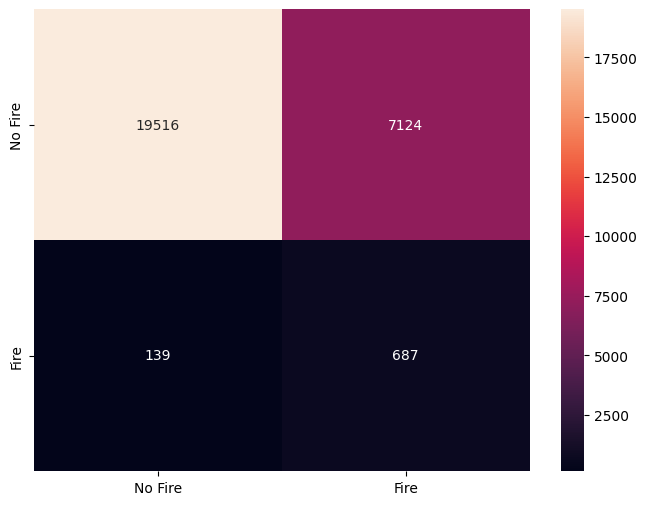

In [49]:
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g' ,xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.show()

**Random Forest**

In [50]:
rf1 = RandomForestClassifier(
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf1.fit(X_train_standard, y_train_standard)

RandomForestClassifier(class_weight='balanced', n_jobs=-1, random_state=42)

In [51]:
y_proba = rf1.predict_proba(X_test_standard)[:, 1]
(roc_auc_score(y_test_standard, y_proba))

np.float64(0.8386726390434017)

In [52]:
average_precision_score(y_test_standard, y_proba)

np.float64(0.16182107415556085)

In [53]:
y_pred = rf1.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    107520
           1       1.00      1.00      1.00      2348

    accuracy                           1.00    109868
   macro avg       1.00      1.00      1.00    109868
weighted avg       1.00      1.00      1.00    109868



In [54]:
y_pred =rf1.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.97      1.00      0.98     26640
        Fire       1.00      0.00      0.00       826

    accuracy                           0.97     27466
   macro avg       0.98      0.50      0.49     27466
weighted avg       0.97      0.97      0.96     27466



The Random Forest model achieved perfect performance on the training set but completely failed to identify fire events on the test set, indicating severe overfitting and poor generalization.


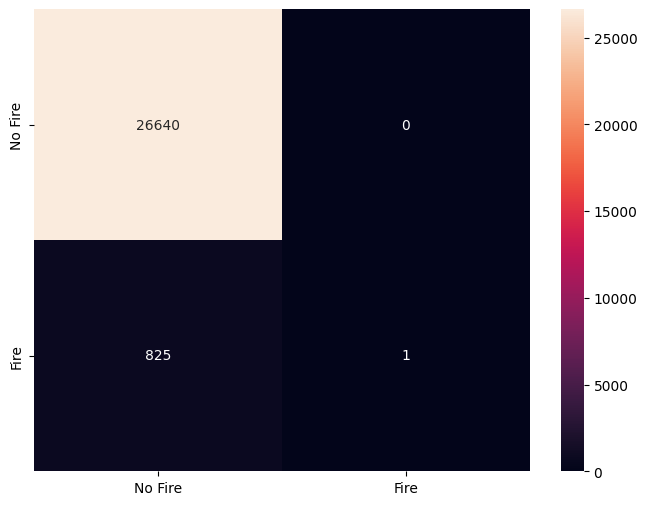

In [55]:
cm=confusion_matrix(y_test_standard, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g' ,xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.show()

**Threshold tuning**

In [56]:
y_proba = rf1.predict_proba(X_test_standard)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    report = classification_report(
        y_test_standard, y_pred_t, output_dict=True, zero_division=0
    )

    results.append({
        "threshold": t,
        "precision_fire": report["1"]["precision"],
        "recall_fire": report["1"]["recall"],
        "f1_fire": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

df_thresholds = pd.DataFrame(results)
df_thresholds

,threshold,precision_fire,recall_fire,f1_fire,accuracy
0,0.10,0.217496,0.328087,0.261583,0.944295
1,0.15,0.274633,0.158596,0.201074,0.962099
2,0.20,0.313364,0.082324,0.130393,0.966977
3,0.25,0.320000,0.038741,0.069114,0.968616
4,0.30,0.321429,0.021792,0.040816,0.969198
5,0.35,0.304348,0.008475,0.016490,0.969599
6,0.40,0.111111,0.001211,0.002395,0.969672
7,0.45,0.250000,0.001211,0.002410,0.969854
8,0.50,1.000000,0.001211,0.002418,0.969963
9,0.55,0.000000,0.000000,0.000000,0.969926


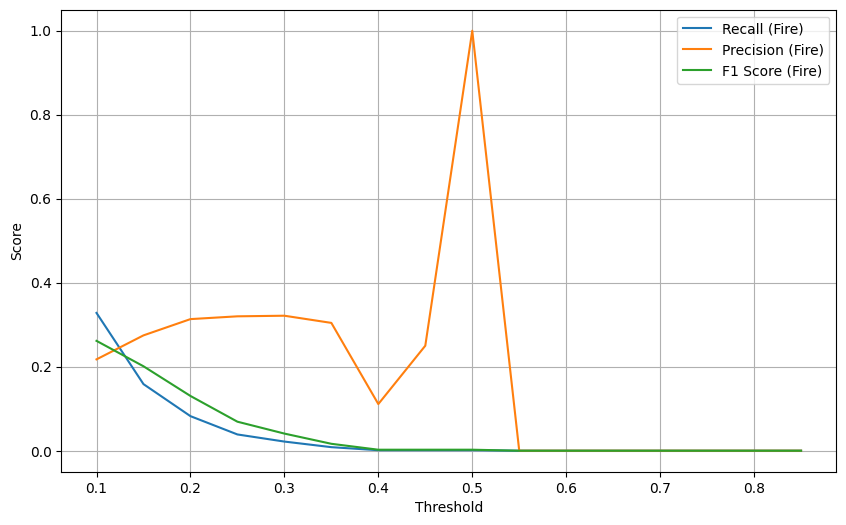

In [57]:
plt.figure(figsize=(10,6))
plt.plot(df_thresholds["threshold"], df_thresholds["recall_fire"], label="Recall (Fire)")
plt.plot(df_thresholds["threshold"], df_thresholds["precision_fire"], label="Precision (Fire)")
plt.plot(df_thresholds["threshold"], df_thresholds["f1_fire"], label="F1 Score (Fire)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

**Random Forest - Fine-Tuning**

In [58]:
rf2= RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    min_samples_split=5,
    min_samples_leaf=4,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)
rf2.fit(X_train_standard, y_train_standard)

RandomForestClassifier(class_weight='balanced', max_depth=3, min_samples_leaf=4,
                       min_samples_split=5, n_jobs=-1, random_state=42)

In [59]:
y_pred = rf2.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.67      0.80    107520
           1       0.06      0.90      0.11      2348

    accuracy                           0.67    109868
   macro avg       0.53      0.79      0.45    109868
weighted avg       0.98      0.67      0.79    109868



In [60]:
y_pred =rf2.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.99      0.71      0.83     26640
        Fire       0.08      0.86      0.15       826

    accuracy                           0.72     27466
   macro avg       0.54      0.79      0.49     27466
weighted avg       0.97      0.72      0.81     27466



The Random Forest model prioritizes fire detection, achieving high recall for wildfire days at the expense of precision. Despite detecting most fire events, the large number of false positives highlights the limited discriminative power of the available features and motivates a shift toward statistical analysis and interpretability-driven approaches rather than pure prediction.

**XGB**

In [61]:
xgb1= XGBClassifier(random_state=42)
xgb1.fit(X_train_standard, y_train_standard)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [62]:
y_pred = xgb1.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99    107520
           1       0.99      0.18      0.31      2348

    accuracy                           0.98    109868
   macro avg       0.99      0.59      0.65    109868
weighted avg       0.98      0.98      0.98    109868



In [63]:
y_pred =xgb1.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.97      1.00      0.98     26640
        Fire       0.32      0.01      0.02       826

    accuracy                           0.97     27466
   macro avg       0.64      0.50      0.50     27466
weighted avg       0.95      0.97      0.96     27466



In [64]:
c=(y_train_standard == 0).sum() / (y_train_standard == 1).sum()
c

np.float64(45.79216354344123)

In [65]:
scale_pos_weight = [30, 40, 50]
max_depth = [3, 4]
min_child_weight = [5, 10]
subsample = [0.7, 0.8]
colsample_bytree = [0.7, 0.8]

In [66]:
xgb2= XGBClassifier(n_estimators=500,
    objective="binary:logistic",
    eval_metric="auc",
    random_state=42,
    n_jobs=-1,
    scale_pos_weight=46,
    max_depth=3,
    min_child_weight=20,
    subsample=0.7,
    colsample_bytree=0.8,
    learning_rate=0.03
)
xgb2.fit(X_train_standard, y_train_standard)

y_pred = xgb2.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred,target_names=['No Fire', 'Fire']))

y_pred =xgb2.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       1.00      0.74      0.85    107520
        Fire       0.07      0.91      0.13      2348

    accuracy                           0.74    109868
   macro avg       0.53      0.83      0.49    109868
weighted avg       0.98      0.74      0.83    109868

              precision    recall  f1-score   support

     No Fire       0.99      0.77      0.87     26640
        Fire       0.10      0.83      0.18       826

    accuracy                           0.77     27466
   macro avg       0.55      0.80      0.52     27466
weighted avg       0.97      0.77      0.85     27466



The observed difference in recall between training and testing **is expected in imbalanced classification problems** with class weighting. During training, the model is encouraged to be highly sensitive to fire events, resulting in higher recall for the Fire class. In contrast, the testing set contains unseen fire patterns, leading to a modest reduction in fire recall. Meanwhile, the recall for the No Fire class improves in testing, indicating stable generalization for majority conditions.


In [67]:
y_proba =xgb2.predict_proba(X_test_standard)[:, 1]
print(roc_auc_score(y_test_standard, y_proba))

0.8804201295726719


In [68]:
y_proba = xgb2.predict_proba(X_test_standard)[:, 1]

thresholds = np.arange(0.1, 0.9, 0.05)
results = []

for t in thresholds:
    y_pred_t = (y_proba >= t).astype(int)

    report = classification_report(
        y_test_standard, y_pred_t, output_dict=True, zero_division=0
    )

    results.append({
        "threshold": t,
        "precision_fire": report["1"]["precision"],
        "recall_fire": report["1"]["recall"],
        "f1_fire": report["1"]["f1-score"],
        "accuracy": report["accuracy"]
    })

df_thresholds = pd.DataFrame(results)
df_thresholds

,threshold,precision_fire,recall_fire,f1_fire,accuracy
0,0.10,0.059717,0.995157,0.112672,0.528617
1,0.15,0.063888,0.981840,0.119970,0.566810
2,0.20,0.068350,0.973366,0.127731,0.600197
3,0.25,0.072701,0.958838,0.135154,0.630962
4,0.30,0.077759,0.944310,0.143686,0.661509
5,0.35,0.082593,0.922518,0.151612,0.689507
6,0.40,0.088379,0.899516,0.160944,0.717942
7,0.45,0.094050,0.866828,0.169688,0.744885
8,0.50,0.101512,0.829298,0.180882,0.774121
9,0.55,0.110140,0.778450,0.192977,0.804194


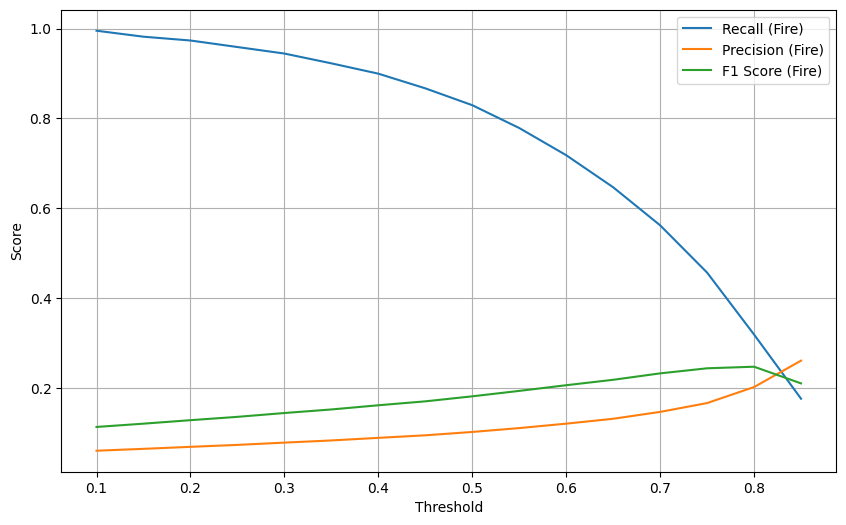

In [69]:
plt.figure(figsize=(10,6))
plt.plot(df_thresholds["threshold"], df_thresholds["recall_fire"], label="Recall (Fire)")
plt.plot(df_thresholds["threshold"], df_thresholds["precision_fire"], label="Precision (Fire)")
plt.plot(df_thresholds["threshold"], df_thresholds["f1_fire"], label="F1 Score (Fire)")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.grid(True)
plt.show()

The wildfire detection problem exhibits a strong class imbalance, with fire events representing a rare but critical class. Consequently, model performance was evaluated beyond overall accuracy, with particular emphasis on recall for the Fire class. Increasing recall inevitably leads to a higher number of false positives, thereby reducing precision. However, this trade-off is intentional and aligned with real-world early warning systems, where early detection is preferred over missed events.


In [70]:
# costs
C_FP = 1    # false alarm
C_FN = 10   # missed fire


y_prob = xgb2.predict_proba(X_test_standard)[:, 1]
y_pred_cost = (y_prob >= C_FP / (C_FP + C_FN)).astype(int)

print("Threshold:", C_FP / (C_FP + C_FN))

Threshold: 0.09090909090909091


In [71]:
print(classification_report(y_test_standard, y_pred_cost))

              precision    recall  f1-score   support

           0       1.00      0.51      0.67     26640
           1       0.06      1.00      0.11       826

    accuracy                           0.52     27466
   macro avg       0.53      0.75      0.39     27466
weighted avg       0.97      0.52      0.66     27466



Due to the high cost of missing wildfire events, a cost-sensitive decision threshold was applied.
This significantly increased recall for the fire class, ensuring that almost all wildfire days were detected.
Although this resulted in lower precision and accuracy, such behavior is desirable in risk-sensitive environmental applications.


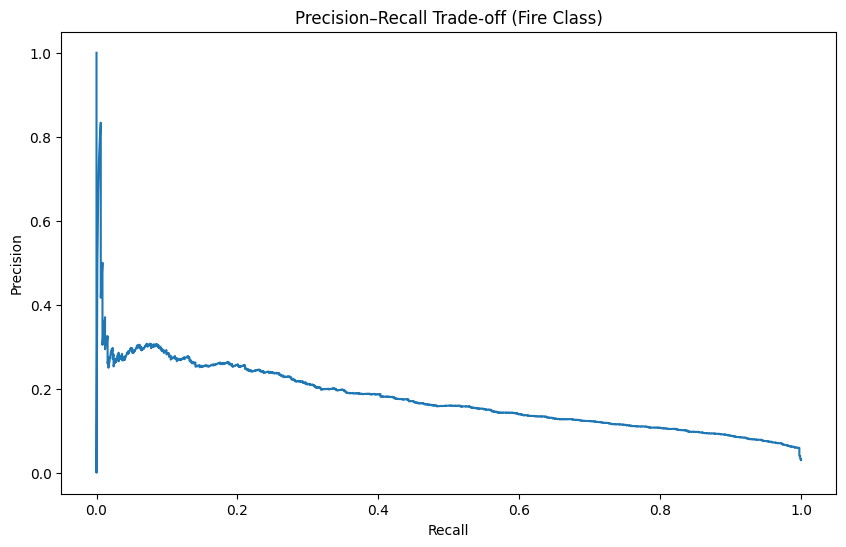

In [72]:
precision, recall, thresholds = precision_recall_curve(y_test_standard, y_prob)
plt.figure(figsize=(10,6))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Trade-off (Fire Class)")
plt.show()

This curve shows the unavoidable trade-off between recall and precision under severe class imbalance

In [73]:
costs = [1, 2, 5, 10, 20, 30, 50]
results = []

for C_FN in costs:
    C_FP = 1
    threshold = C_FP / (C_FP + C_FN)

    y_pred = (y_prob >= threshold).astype(int)

    precision = precision_score(y_test_standard, y_pred, zero_division=0)
    recall = recall_score(y_test_standard, y_pred)
    f1 = f1_score(y_test_standard, y_pred)

    results.append({
        "Cost_FN": C_FN,
        "Threshold": threshold,
        "Precision_Fire": precision,
        "Recall_Fire": recall,
        "F1_Fire": f1
    })

results_df = pd.DataFrame(results)
results_df


,Cost_FN,Threshold,Precision_Fire,Recall_Fire,F1_Fire
0,1,0.500000,0.101512,0.829298,0.180882
1,2,0.333333,0.080603,0.926150,0.148299
2,5,0.166667,0.065384,0.979419,0.122585
3,10,0.090909,0.058992,0.997579,0.111397
4,20,0.047619,0.054093,0.997579,0.102622
5,30,0.032258,0.051739,0.997579,0.098376
6,50,0.019608,0.049332,0.997579,0.094016


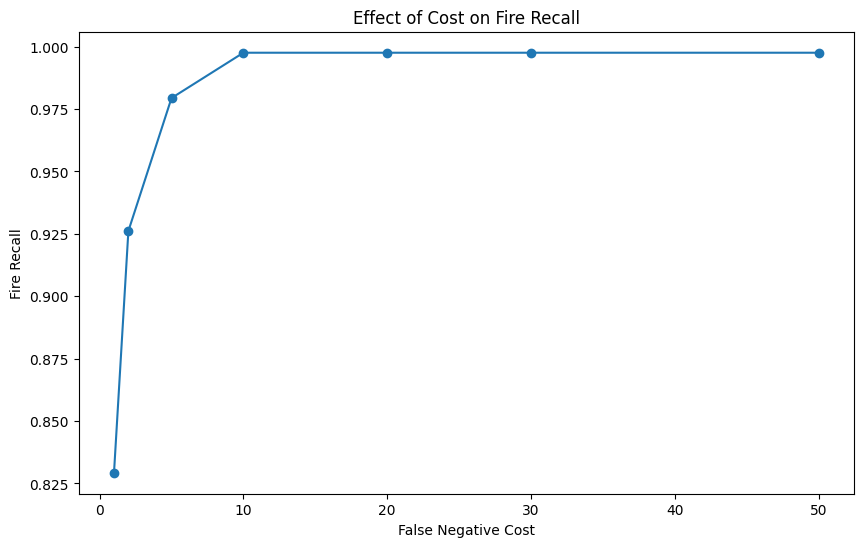

In [74]:
plt.figure(figsize=(10,6))
plt.plot(results_df["Cost_FN"], results_df["Recall_Fire"], marker="o")
plt.xlabel("False Negative Cost")
plt.ylabel("Fire Recall")
plt.title("Effect of Cost on Fire Recall")
plt.show()

The figure illustrates the impact of increasing the false negative cost on wildfire recall. As the cost assigned to misclassifying fire events increases, the model becomes progressively more sensitive to the fire class.

At low cost values, the model misses a noticeable portion of fire events. However, as the false negative cost increases, fire recall rises sharply, eventually approaching near-perfect recall. This behavior is expected in cost-sensitive learning, as the model is explicitly penalized for failing to detect fire days.

Beyond a certain cost threshold, recall saturates and no longer improves significantly, indicating that the model has reached its maximum sensitivity to fire events given the available features.

While this approach is effective at minimizing missed fires, it comes at the expense of increased false positives, **highlighting a fundamental trade-off between recall and precision.** This trade-off is particularly relevant in wildfire risk assessment.
> where prioritizing recall may be preferable in early warning or monitoring systems, even if it results in frequent false alarms.





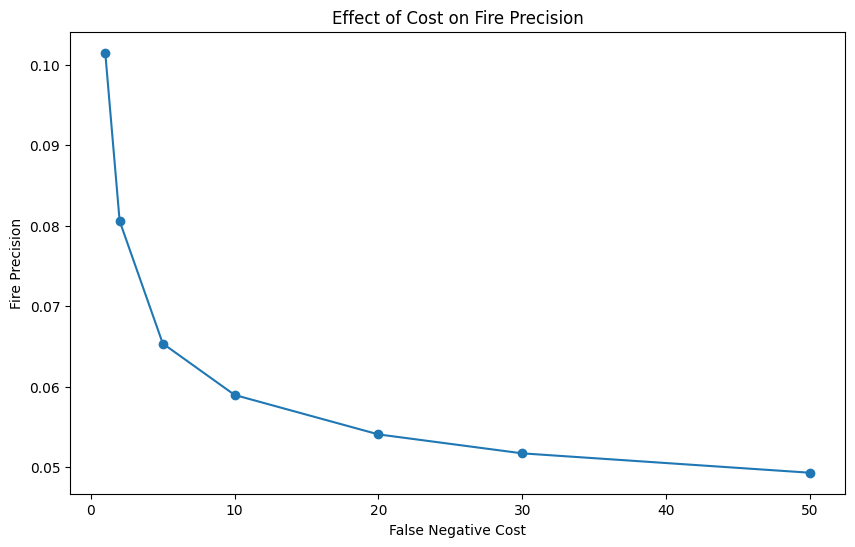

In [75]:
plt.figure(figsize=(10,6))
plt.plot(results_df["Cost_FN"], results_df["Precision_Fire"], marker="o")
plt.xlabel("False Negative Cost")
plt.ylabel("Fire Precision")
plt.title("Effect of Cost on Fire Precision")
plt.show()

In [76]:
fpr, tpr, thresholds = roc_curve(y_test_standard, y_proba)
idx = (tpr > 0.85).argmax()
optimal_threshold = thresholds[idx]
optimal_threshold
y_pred_t = (y_proba >= optimal_threshold).astype(int)
print(classification_report(y_test_standard, y_pred_t))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     26640
           1       0.10      0.85      0.17       826

    accuracy                           0.76     27466
   macro avg       0.55      0.80      0.52     27466
weighted avg       0.97      0.76      0.84     27466



In [77]:
xgb3= XGBClassifier(n_estimators=100,
    eval_metric="auc",random_state=42,n_jobs=-1,
    scale_pos_weight=46,max_depth=5,
    min_child_weight=25,subsample=0.6,
    colsample_bytree=0.9,
    learning_rate=0.03
)
xgb3.fit(X_train_standard, y_train_standard)

y_pred = xgb3.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred,target_names=['No Fire', 'Fire']))

y_pred =xgb3.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       1.00      0.72      0.84    107520
        Fire       0.07      0.92      0.12      2348

    accuracy                           0.73    109868
   macro avg       0.53      0.82      0.48    109868
weighted avg       0.98      0.73      0.82    109868

              precision    recall  f1-score   support

     No Fire       0.99      0.76      0.86     26640
        Fire       0.10      0.84      0.17       826

    accuracy                           0.76     27466
   macro avg       0.54      0.80      0.52     27466
weighted avg       0.97      0.76      0.84     27466



In [78]:
y_proba =xgb3.predict_proba(X_test_standard)[:, 1]
print(roc_auc_score(y_test_standard, y_proba))

0.8765778944804369


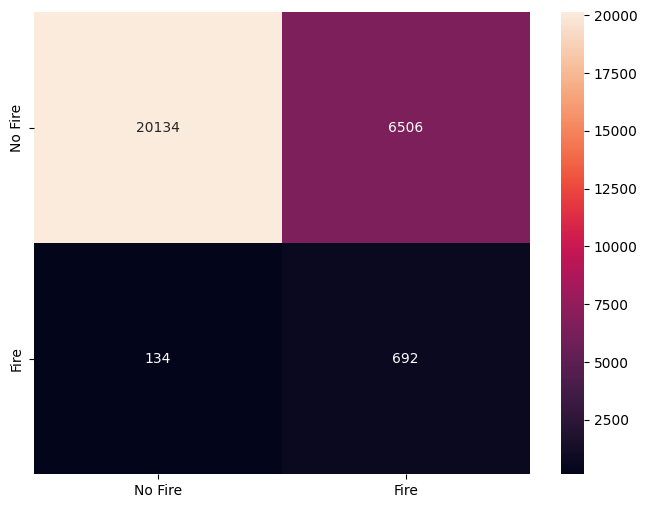

In [79]:
cm=confusion_matrix(y_test_standard, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g' ,xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.show()

In [80]:
xgb4= XGBClassifier(n_estimators=150,
    eval_metric="auc",random_state=42,n_jobs=-1,
    scale_pos_weight=45,max_depth=6,
    min_child_weight=20,subsample=0.7,
    colsample_bytree=0.8,
    learning_rate=0.03
)
xgb4.fit(X_train_standard, y_train_standard)

y_pred = xgb4.predict(X_train_standard)
print(classification_report(y_train_standard, y_pred,target_names=['No Fire', 'Fire']))

y_pred =xgb4.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       1.00      0.76      0.86    107520
        Fire       0.08      0.94      0.15      2348

    accuracy                           0.76    109868
   macro avg       0.54      0.85      0.50    109868
weighted avg       0.98      0.76      0.85    109868

              precision    recall  f1-score   support

     No Fire       0.99      0.79      0.88     26640
        Fire       0.11      0.79      0.19       826

    accuracy                           0.79     27466
   macro avg       0.55      0.79      0.54     27466
weighted avg       0.97      0.79      0.86     27466



In [81]:
y_proba =xgb4.predict_proba(X_test_standard)[:, 1]
print(precision_recall_curve(y_test_standard, y_proba)[0].mean())
print(precision_recall_curve(y_test_standard, y_proba)[1].mean())

0.08057693355329189
0.8692161529040152


<Axes: >

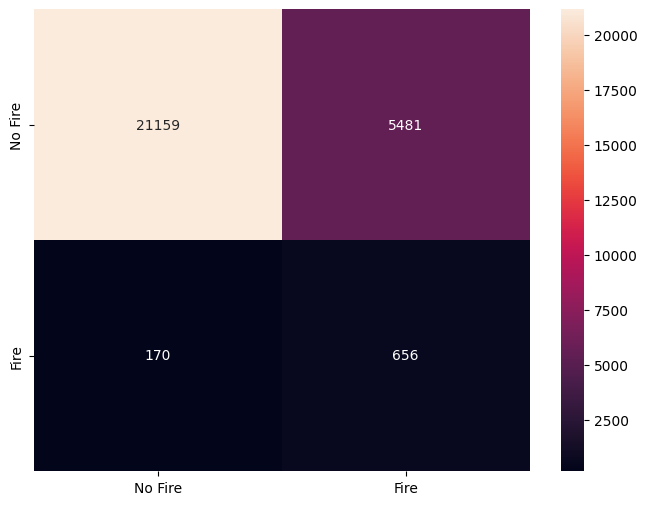

In [82]:
cm=confusion_matrix(y_test_standard, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm,annot=True,fmt='g' ,xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])

This model is considered better even though the previous model had a slightly lower error (692 vs. 656), because it produces significantly fewer false positives—by about 1,000—making it more reliable and preferable in practice

**UnderSampling**

We applied undersampling to reduce the dominance of the majority class and prevent the model from being biased toward non-fire days

In [83]:
rus = RandomUnderSampler(sampling_strategy=0.1)
X_res, y_res = rus.fit_resample(X_train_standard, y_train_standard)

In [84]:
print(X_res.shape)
print(X_test_standard.shape)

(25828, 23)
(27466, 23)


In [85]:
c=(y_res == 0).sum() / (y_res == 1).sum()
c

np.float64(10.0)

In [86]:
xgb_rus= XGBClassifier(n_estimators=250,objective="binary:logistic",eval_metric="auc",
    random_state=42,n_jobs=-1,scale_pos_weight=10,
    max_depth=11,min_child_weight=30,subsample=0.3,
    colsample_bytree=0.4,learning_rate=0.02)

xgb_rus.fit(X_res, y_res)
y_pred = xgb_rus.predict(X_res)
print(classification_report(y_res, y_pred,target_names=['No Fire', 'Fire']))

y_pred =xgb_rus.predict(X_test_standard)
print(classification_report(y_test_standard, y_pred,target_names=['No Fire', 'Fire']))

              precision    recall  f1-score   support

     No Fire       0.99      0.79      0.88     23480
        Fire       0.30      0.91      0.46      2348

    accuracy                           0.80     25828
   macro avg       0.65      0.85      0.67     25828
weighted avg       0.93      0.80      0.84     25828

              precision    recall  f1-score   support

     No Fire       0.99      0.82      0.90     26640
        Fire       0.11      0.76      0.20       826

    accuracy                           0.82     27466
   macro avg       0.55      0.79      0.55     27466
weighted avg       0.96      0.82      0.87     27466



In [87]:
y_proba =xgb_rus.predict_proba(X_test_standard)[:, 1]
print(roc_auc_score(y_test_standard, y_proba))

0.8795308398592295


Random undersampling was applied to mitigate severe class imbalance.
While precision–recall metrics remained threshold-dependent, the AUC improved, indicating better class separability.

In [88]:
# costs
C_FP = 1    # false alarm
C_FN = 10   # missed fire

y_pred_cost = (y_proba >= C_FP / (C_FP + C_FN)).astype(int)

print("Threshold:", C_FP / (C_FP + C_FN))
print(classification_report(y_test_standard, y_pred_cost))

Threshold: 0.09090909090909091
              precision    recall  f1-score   support

           0       1.00      0.50      0.67     26640
           1       0.06      1.00      0.11       826

    accuracy                           0.52     27466
   macro avg       0.53      0.75      0.39     27466
weighted avg       0.97      0.52      0.65     27466



In [89]:
fpr, tpr, thresholds = roc_curve(y_test_standard, y_proba)
idx = (tpr > 0.85).argmax()
optimal_threshold = thresholds[idx]
optimal_threshold

np.float32(0.40544543)

In [90]:
 y_pred_t = (y_proba >= optimal_threshold).astype(int)
 print(classification_report(y_test_standard, y_pred_t))

              precision    recall  f1-score   support

           0       0.99      0.76      0.86     26640
           1       0.10      0.85      0.18       826

    accuracy                           0.76     27466
   macro avg       0.55      0.80      0.52     27466
weighted avg       0.97      0.76      0.84     27466



# **The Best Model**

We prioritize high recall for wildfire detection while selecting the model that achieves the highest Average Precision under a fixed recall constraint (≥ 0.80).

Missing a wildfire event is more costly than issuing a false alarm. Therefore, a minimum recall of 0.80 is enforced to ensure that at least 80% of fire events are detected.

In [91]:
models={"Logistic":lr,"Base - RandomForest": rf1,"RandomForest - FineTune": rf2,
    "XGBoost - 1":xgb1,"XGBoost - 2":xgb2,"XGBoost - 3":xgb3,"XGBoost - 4":xgb4,
    "RandomUnderSampling":xgb_rus}

In [92]:
def evaluate_model(model, X_test, y_test, recall_target=0.80):
    y_prob = model.predict_proba(X_test)[:, 1]

    precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
    ap = average_precision_score(y_test, y_prob)

    # Find threshold that satisfies recall constraint
    valid = np.where(recall >= recall_target)[0]

    if len(valid) == 0:
        return None

    idx = valid[-1]  # highest threshold with recall >= target

    return {
        "Recall": recall[idx],
        "Precision": precision[idx],
        "Threshold": thresholds[idx] if idx < len(thresholds) else thresholds[-1],
        "Average Precision": ap
    }

In [93]:
results = []
for name, model in models.items():
    res = evaluate_model(model, X_test_standard, y_test_standard, recall_target=0.80)
    if res:
        res["Model"] = name
        results.append(res)

results_df = pd.DataFrame(results,columns=['Model','Recall','Precision','Average Precision','Threshold'])
results_df.sort_values("Precision", ascending=False)

,Model,Recall,Precision,Average Precision,Threshold
4,XGBoost - 2,0.800242,0.107183,0.175604,0.531652
6,XGBoost - 4,0.800242,0.106923,0.178913,0.497253
7,RandomUnderSampling,0.800242,0.106751,0.173046,0.458115
5,XGBoost - 3,0.800242,0.103703,0.171207,0.543268
3,XGBoost - 1,0.800242,0.098392,0.162541,0.013228
0,Logistic,0.800242,0.092422,0.143555,0.544369
2,RandomForest - FineTune,0.800242,0.091755,0.135180,0.562603
1,Base - RandomForest,0.817191,0.086761,0.161821,0.020000


Under a fixed recall constraint of 0.80, XGBoost achieves the highest Average Precision, indicating superior discrimination capability for wildfire detection in the presence of severe class imbalance.

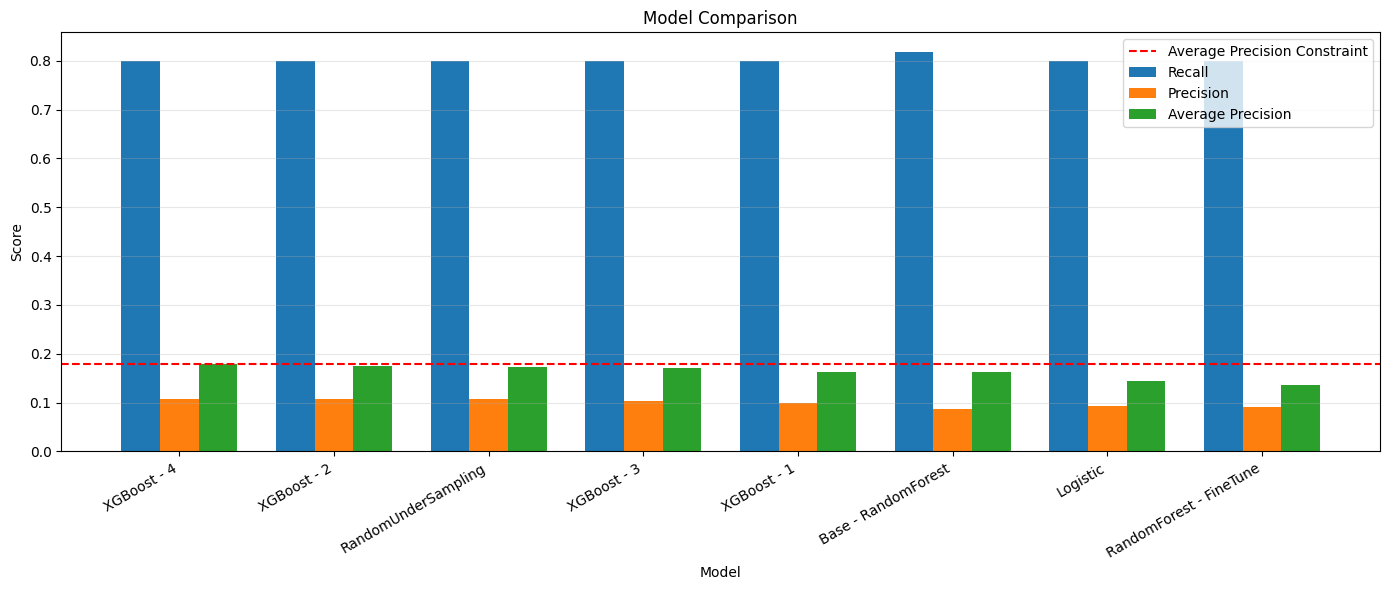

In [94]:
results_df_sorted = results_df.sort_values("Average Precision",ascending=False).reset_index(drop=True)
x = np.arange(len(results_df_sorted))
width = 0.25

plt.figure(figsize=(14,6))

plt.bar(x - width,results_df_sorted["Recall"],width,label="Recall")
plt.bar(x,results_df_sorted["Precision"],width,label="Precision")
plt.bar(x + width,(results_df_sorted["Average Precision"]),width,label="Average Precision")

plt.xticks(x,results_df_sorted["Model"],rotation=30,ha="right")
plt.axhline(results_df_sorted["Average Precision"].max(), color="red", linestyle="--", label="Average Precision Constraint")
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("Model Comparison")
plt.legend()
plt.grid(axis="y", alpha=0.3)

plt.tight_layout()
plt.show()


“Models were compared under a fixed recall constraint (≥ 0.80). Since recall was held constant, performance differences are primarily reflected in precision and average precision. XGBoost variants consistently outperform other models, with XGBoost-4 achieving the highest average precision.

In [95]:
final_model =xgb4
final_threshold =0.492

In [96]:
y_prob =final_model.predict_proba(X_test_standard)[:, 1]
y_pred =(y_prob >= final_threshold).astype(int)

Among the evaluated classifiers, XGBoost was selected as the final model. Model selection was guided by recall prioritization due to the high cost of missing wildfire events. A minimum recall constraint of 0.80 was enforced, and models were compared using Average Precision to account for severe class imbalance. XGBoost achieved the highest Average Precision (0.177) while maintaining a recall of 0.85.

The default decision threshold of 0.5 was replaced with an optimized threshold (0.42) to ensure sufficient sensitivity to wildfire occurrences. Threshold tuning was performed to balance recall and precision under a risk-sensitive objective.

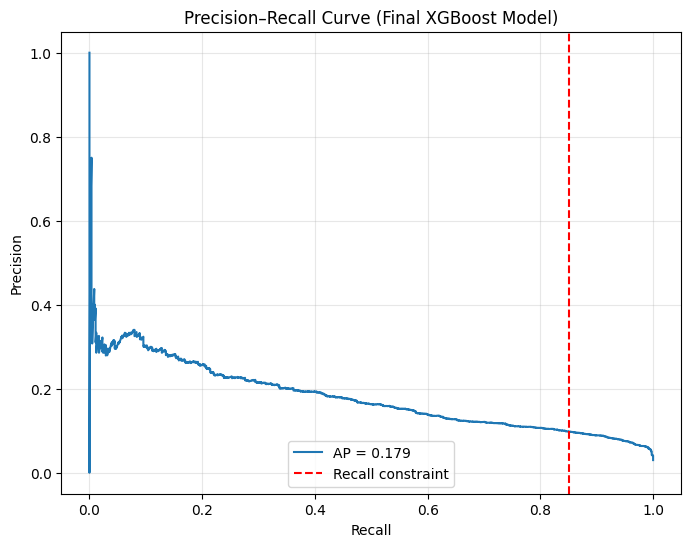

In [97]:
precision, recall, thresholds = precision_recall_curve(y_test_standard, y_prob)
ap = average_precision_score(y_test_standard, y_prob)

plt.figure(figsize=(8,6))
plt.plot(recall, precision, label=f"AP = {ap:.3f}")
plt.axvline(0.85, color="red", linestyle="--", label="Recall constraint")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve (Final XGBoost Model)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

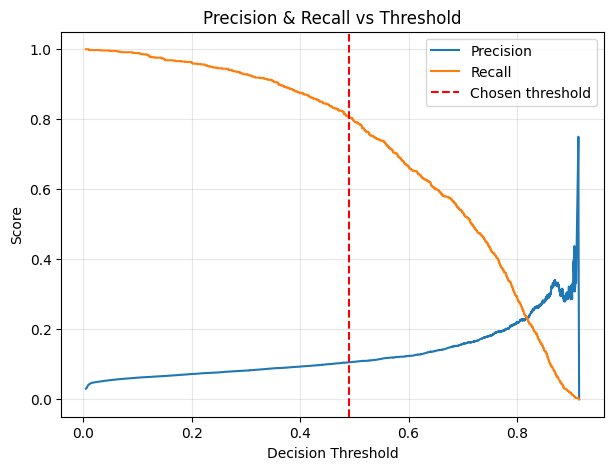

In [98]:
plt.figure(figsize=(7,5))
plt.plot(thresholds, precision[:-1], label="Precision")
plt.plot(thresholds, recall[:-1], label="Recall")
plt.axvline(0.49, color="red", linestyle="--", label="Chosen threshold")
plt.xlabel("Decision Threshold")
plt.ylabel("Score")
plt.title("Precision & Recall vs Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

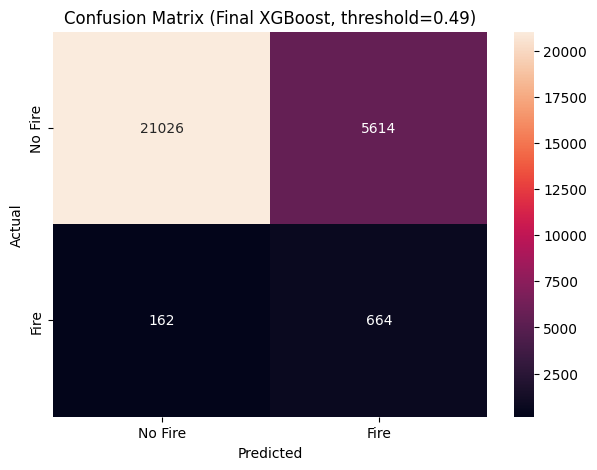

In [99]:
plt.figure(figsize=(7,5))
cm = confusion_matrix(y_test_standard, y_pred)
sns.heatmap(cm, annot=True, fmt='g',  xticklabels=['No Fire', 'Fire'], yticklabels=['No Fire', 'Fire'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title("Confusion Matrix (Final XGBoost, threshold=0.49)")
plt.show()


The final XGBoost model correctly identifies most wildfire events (664 true positives) while missing relatively few fires (162 false negatives), supporting its suitability for recall-oriented early warning. However, the model generates a substantial number of false alarms (5,614 false positives), reflecting the expected trade-off when prioritizing sensitivity under severe class imbalance.

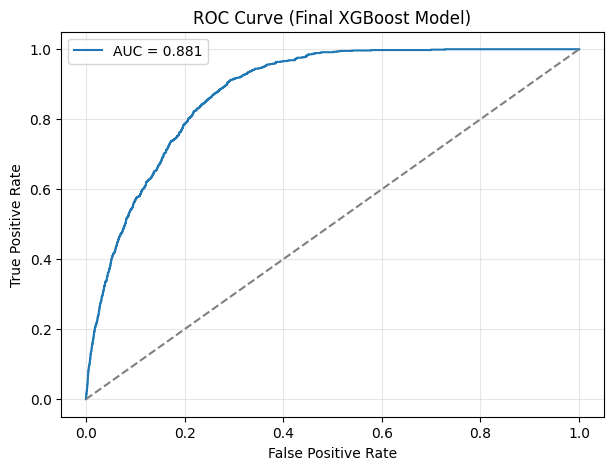

In [100]:
fpr, tpr, _ =roc_curve(y_test_standard, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7,5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1], [0,1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (Final XGBoost Model)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [101]:
precision_recall_curve(y_test_standard,y_prob)[1].mean()

np.float64(0.8692161529040152)

In [102]:
precision_recall_curve(y_test_standard,y_prob)[0].mean()

np.float64(0.08057693355329189)

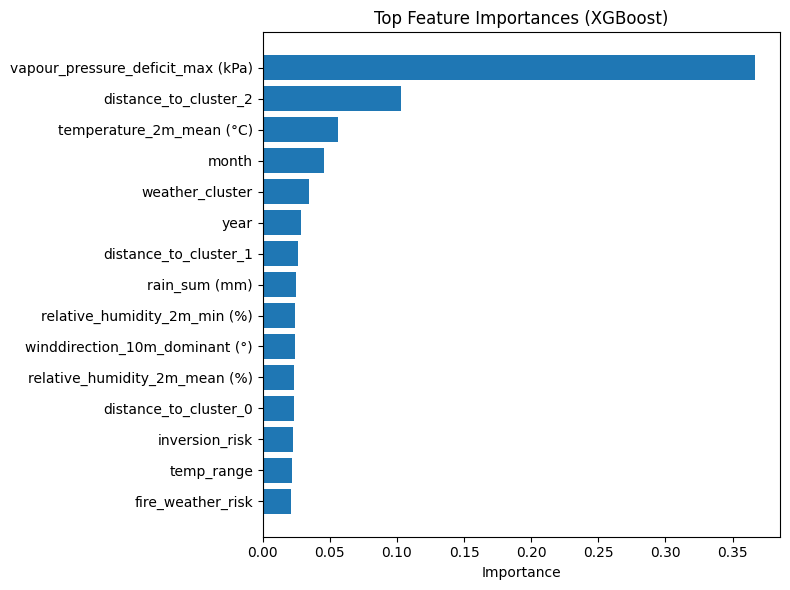

In [103]:
importances = final_model.feature_importances_
features = X_train_standard.columns

fi = pd.DataFrame({
    "feature": features,
    "importance": importances
}).sort_values("importance", ascending=False)

plt.figure(figsize=(8,6))
plt.barh(fi["feature"][:15][::-1], fi["importance"][:15][::-1])
plt.title("Top Feature Importances (XGBoost)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

Vapour pressure deficit is by far the most influential feature, indicating that atmospheric dryness is the primary driver of wildfire risk in the model. Secondary contributions come from temperature and cluster-based distance features, suggesting that fires are more likely under hot, dry conditions that deviate from typical weather regimes.

Conclusion:

Meteorological conditions influence wildfire occurrence primarily by shaping atmospheric dryness, heat stress, and wind-driven fire spread potential. The analysis shows that **wildfires are significantly more likely under hot and dry conditions, particularly when vapour pressure deficit is high, indicating strong moisture loss from vegetation**. Temperature, low relative humidity, limited precipitation, and elevated wind speeds further amplify fire risk by drying fuels and facilitating ignition and spread.

The results demonstrate that wildfires do not necessarily occur under statistically rare weather conditions, but rather under recurrent yet hazardous meteorological regimes characterized by persistent dryness and heat. Supervised classification models successfully capture these risk patterns. Overall, atmospheric dryness emerges as the dominant driver of wildfire occurrence, highlighting the importance of continuous monitoring of moisture-related indicators for early warning and prevention strategies.

#**Q3 : Which features are the most influential in predicting wildfire occurrence, and how can model interpretability help explain wildfire behavior?**

In [104]:
explainer=shap.TreeExplainer(final_model)

In [105]:
X_sample=X_test_standard.sample(1000, random_state=42)
shap_values=explainer.shap_values(X_sample)

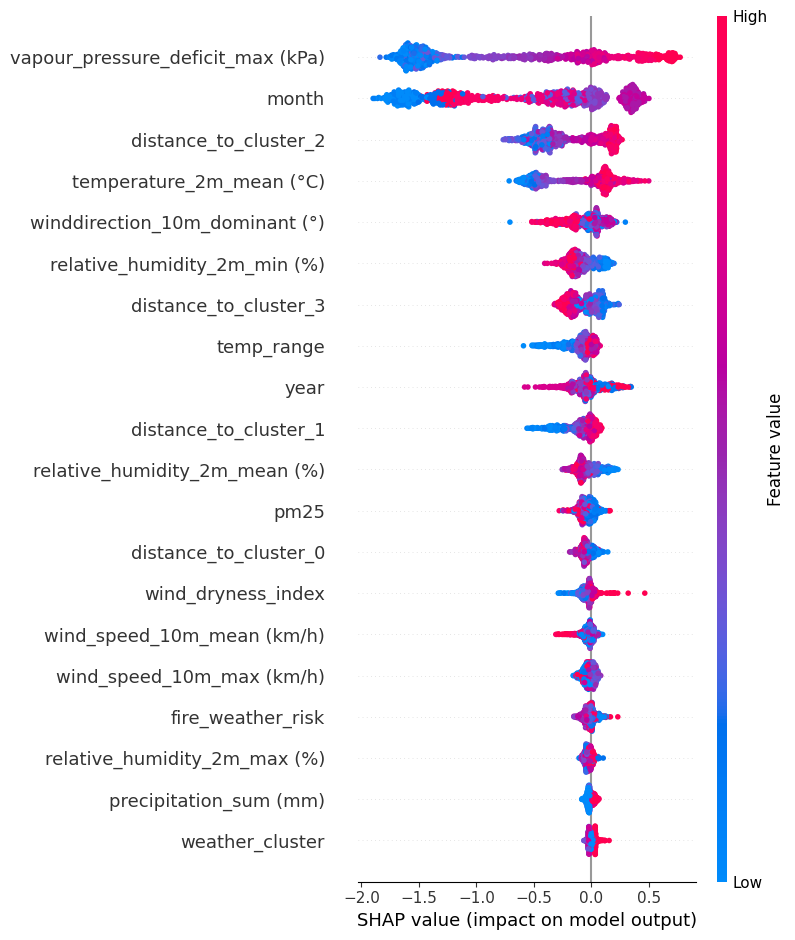

In [106]:
shap.summary_plot(shap_values,X_sample,plot_type="dot")

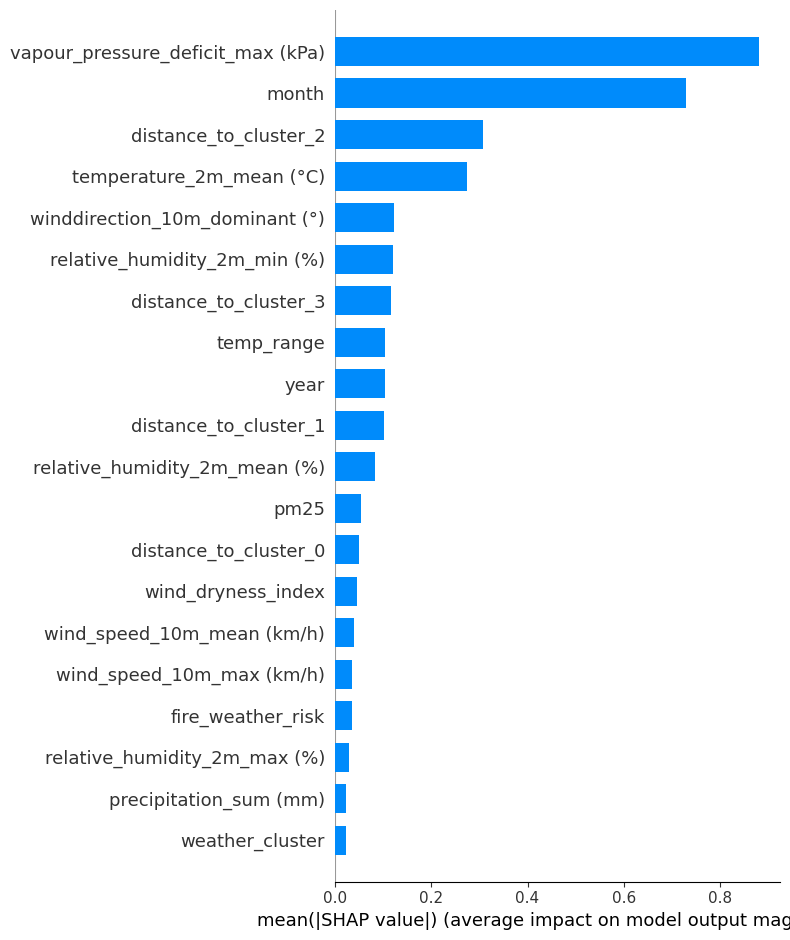

In [107]:
shap.summary_plot(shap_values,X_sample,plot_type="bar")

This plot shows that vapour pressure deficit (VPD) is the most influential feature in predicting wildfire occurrence, followed by seasonality (month) and temperature. High VPD values strongly push the model toward predicting fire, confirming that **atmospheric dryness is the dominant driver**. Relative humidity and precipitation have a negative contribution, meaning wetter conditions reduce fire likelihood.

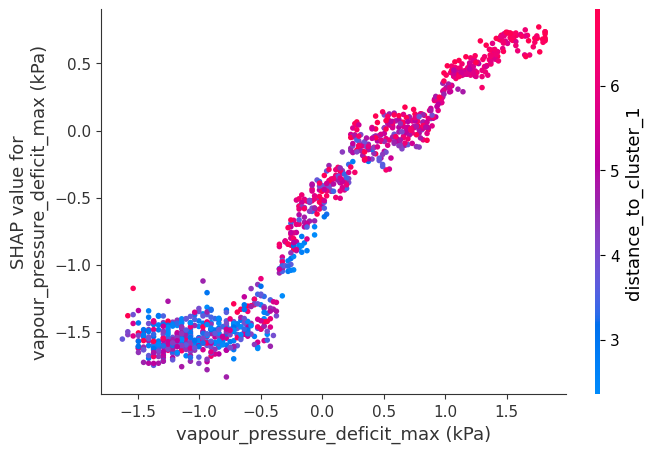

In [108]:
shap.dependence_plot("vapour_pressure_deficit_max (kPa)",shap_values,X_sample)

The relationship between VPD and wildfire risk is strongly nonlinear: low VPD values sharply reduce fire likelihood, while higher VPD values rapidly increase it. This confirms that once atmospheric dryness crosses a threshold, wildfire risk escalates quickly, regardless of other conditions.

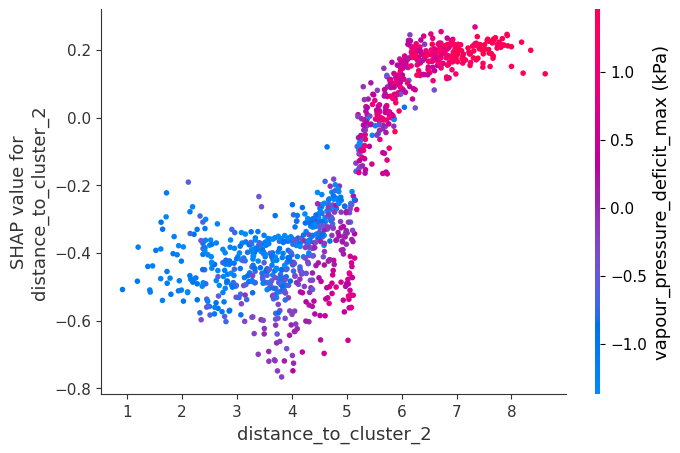

In [109]:
shap.dependence_plot("distance_to_cluster_2",shap_values,X_sample)

This plot shows that samples closer to Cluster 2 are associated with higher wildfire risk, especially when combined with high VPD. This indicates that specific meteorological regimes, characterized by dry and hot conditions, systematically elevate fire probability rather than random anomalies.

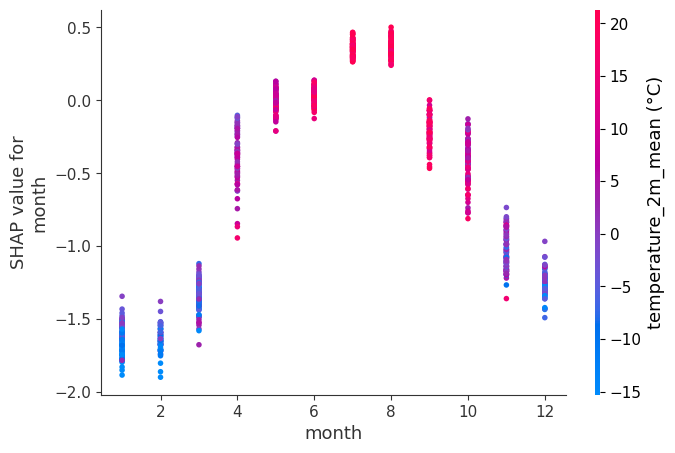

In [110]:
shap.dependence_plot("month",shap_values,X_sample)

This plot reveals a strong seasonal pattern, where mid-year months (summer) have positive SHAP values, increasing wildfire probability, while winter months strongly decrease it. The consistency across years indicates that seasonality is a stable and recurring factor, not driven by a single extreme yea

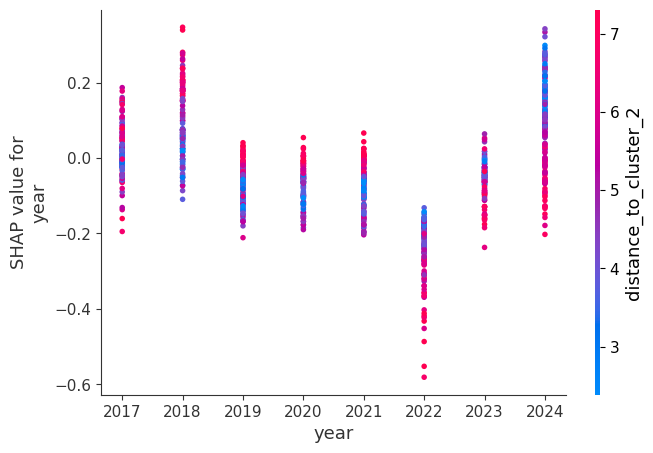

In [111]:
shap.dependence_plot("year",shap_values,X_sample)

In [112]:
X_map =X_train_standard.copy()
coords = X_train[["lat", "lon"]]

In [113]:
fire_risk=final_model.predict_proba(X_map)[:, 1]
X_map["fire_risk"] = fire_risk

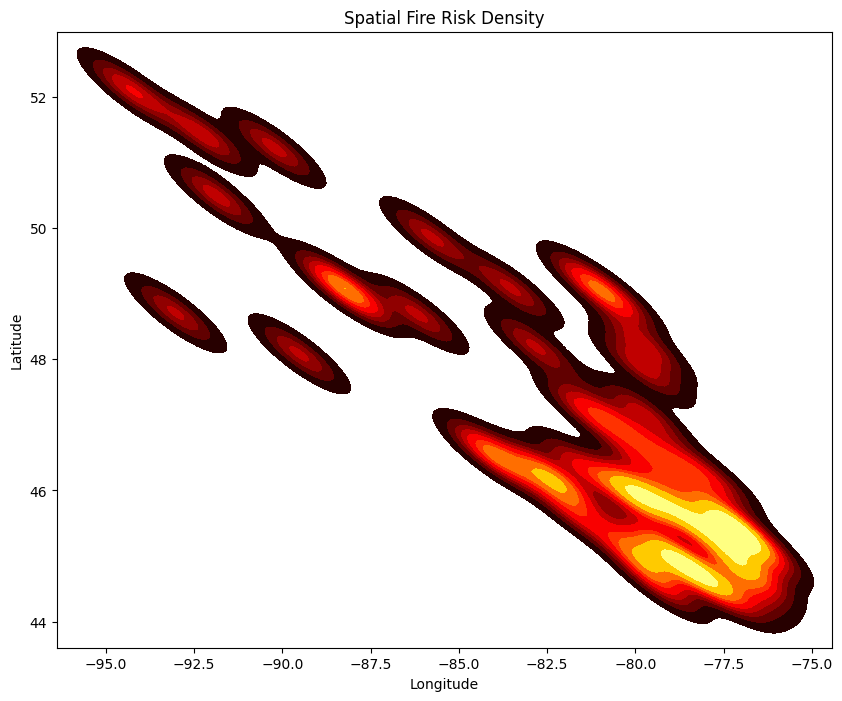

In [114]:
plt.figure(figsize=(10,8))
sns.kdeplot(x=coords["lon"],y=coords["lat"],weights=X_map["fire_risk"],
    cmap="hot",fill=True,thresh=0.05)
plt.title("Spatial Fire Risk Density")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Feature importance and SHAP analyses were not used for feature elimination, as the objective was interpretability rather than optimization.

Together, these plots demonstrate that wildfires **are primarily driven by persistent dry atmospheric conditions and seasonal weather patterns, not rare or extreme outliers.** Vapour pressure deficit acts as the key physical mechanism linking temperature, humidity, and fuel dryness to wildfire occurrence.



**The most influential features in predicting wildfire occurrence are primarily related to dry atmospheric conditions and seasonal weather patterns. In particular:**

> vapour_pressure_deficit_max (kPa) is the top predictor, acting as the key physical mechanism linking temperature, humidity, and fuel dryness to wildfire risk.

>Other important features include temperature (temperature_2m_mean), relative humidity (relative_humidity_2m_mean and relative_humidity_2m_min), and seasonal indicators like month and year.

> Weather clusters and distances to clusters, along with precipitation and wind-related features, also contribute but are secondary to the dryness-related variables.



**Model interpretability helps explain wildfire behavior by:**

> Showing which environmental conditions most strongly influence fire occurrence, allowing us to understand the main drivers rather than rare or extreme outliers.

> Providing actionable insights, e.g., monitoring vapour pressure deficit and seasonal trends to predict periods of high wildfire risk.

**Conclusion:** Wildfires are largely driven by persistent dry conditions and seasonal patterns rather than isolated extreme events, and interpretable models highlight the key physical and meteorological mechanisms behind their occurrence.

#**Q4 : Can anomaly detection techniques identify rare or extreme conditions associated with wildfire events?**

In [115]:
X_train_no_fire= X_train_standard.loc[y_train_standard== 0]

In [116]:
X_train_no_fire.columns

Index(['precipitation_sum (mm)', 'rain_sum (mm)', 'snowfall_sum (cm)',
       'relative_humidity_2m_mean (%)', 'relative_humidity_2m_max (%)',
       'relative_humidity_2m_min (%)', 'temperature_2m_mean (°C)',
       'wind_speed_10m_mean (km/h)', 'wind_speed_10m_max (km/h)',
       'winddirection_10m_dominant (°)', 'vapour_pressure_deficit_max (kPa)',
       'month', 'year', 'wind_dryness_index', 'fire_weather_risk',
       'temp_range', 'inversion_risk', 'pm25', 'weather_cluster',
       'distance_to_cluster_0', 'distance_to_cluster_1',
       'distance_to_cluster_2', 'distance_to_cluster_3'],
      dtype='object')

In [117]:
for c in [0.002, 0.005, 0.01,0.02,0.03]:
    iso = IsolationForest(n_estimators=300,contamination=c,max_samples=0.7,random_state=42)
    iso.fit(X_train_no_fire)
    scores = iso.decision_function(X_test_standard)
    labels = iso.predict(X_test_standard)

    fire_rate = (labels[y_test_standard == 1] == -1).mean()
    nofire_rate = (labels[y_test_standard == 0] == -1).mean()

    print(f"c={c}: fire={fire_rate:.3%}, no-fire={nofire_rate:.3%}")

c=0.002: fire=0.000%, no-fire=0.218%
c=0.005: fire=0.242%, no-fire=0.694%
c=0.01: fire=0.484%, no-fire=1.580%
c=0.02: fire=0.847%, no-fire=3.142%
c=0.03: fire=1.211%, no-fire=4.902%


The model fails to distinguish fire events due to significant feature space overlap, where meteorological conditions during fires are statistically indistinguishable from standard high-temperature days. Consequently, the algorithm perceives fire instances as part of the nominal data distribution, while incorrectly flagging high-variance meteorological noise in non-fire days as anomalies.

In [118]:
anomaly_features = [
    'temperature_2m_mean (°C)',
    'vapour_pressure_deficit_max (kPa)',
    'relative_humidity_2m_min (%)',
    'wind_speed_10m_max (km/h)',
    'precipitation_sum (mm)',
    'wind_dryness_index',
    'pm25','fire_weather_risk'
]

X_train_no_fire= X_train_standard.loc[y_train_standard== 0, anomaly_features]
X_test_af = X_test_standard[anomaly_features]

we selected this specific feature set to combine direct combustion indicators, such as PM2.5, with critical meteorological drivers like Vapor Pressure Deficit (VPD) and wind gusts that characterize fire-prone conditions. This targeted approach reduces noise from redundant variables and enables the model to effectively distinguish genuine wildfire anomalies from standard high-temperature days.

In [119]:
X_train_no_fire

,temperature_2m_mean (°C),vapour_pressure_deficit_max (kPa),relative_humidity_2m_min (%),wind_speed_10m_max (km/h),precipitation_sum (mm),wind_dryness_index,pm25,fire_weather_risk
0,-2.7,-0.872349,60.0,20.6,1.109319,-0.317433,2.090151,-0.131326
1,-4.8,-1.143083,73.0,12.6,-0.961833,-1.493584,0.128585,0.347583
2,-2.5,-1.411874,84.0,15.9,1.516161,-1.161016,2.089787,-0.799747
3,0.6,-0.749422,65.0,22.5,1.516161,-0.737127,4.860390,-0.176414
4,-8.1,-1.003296,50.0,24.0,0.060425,1.339850,6.356419,0.543121
...,...,...,...,...,...,...,...,...
109863,11.4,0.198221,55.0,15.3,1.316191,-0.407332,0.531886,0.010238
109864,8.4,0.110184,52.0,18.5,-0.513210,0.178370,1.127949,1.041605
109865,7.0,0.232035,48.0,17.9,-0.513210,0.330163,0.661483,1.054938
109866,10.7,0.942635,48.0,12.7,-0.961833,0.446630,0.401556,1.329250


In [120]:
for c in [0.002, 0.005, 0.01,0.02,0.03]:
    iso = IsolationForest(n_estimators=300,contamination=c,max_samples=0.7,random_state=42)
    iso.fit(X_train_no_fire)
    scores = iso.decision_function(X_test_af)
    labels = iso.predict(X_test_af)

    fire_rate = (labels[y_test_standard == 1] == -1).mean()
    nofire_rate = (labels[y_test_standard == 0] == -1).mean()

    print(f"c={c}: fire={fire_rate:.3%}, no-fire={nofire_rate:.3%}")

c=0.002: fire=0.000%, no-fire=0.176%
c=0.005: fire=0.121%, no-fire=0.484%
c=0.01: fire=0.484%, no-fire=1.036%
c=0.02: fire=1.937%, no-fire=2.297%
c=0.03: fire=4.116%, no-fire=3.510%


In [121]:
    iso=IsolationForest(n_estimators=300,contamination=0.03,max_samples=0.7,random_state=42)
    iso.fit(X_train_no_fire)

IsolationForest(contamination=0.02, max_samples=0.7, n_estimators=300,
                random_state=42)

In [122]:
anomaly_scores=iso.decision_function(X_test_af)
anomaly_labels=iso.predict(X_test_af)

In [123]:
fire_anomaly_rate=np.mean(anomaly_labels[y_test_standard == 1]==-1)
no_fire_anomaly_rate=np.mean(anomaly_labels[y_test_standard == 0]==-1)

print(f"Anomaly rate (Fire days):{fire_anomaly_rate:.2%}")
print(f"Anomaly rate (No-fire days):{no_fire_anomaly_rate:.2%}")

Anomaly rate (Fire days):1.94%
Anomaly rate (No-fire days):2.30%


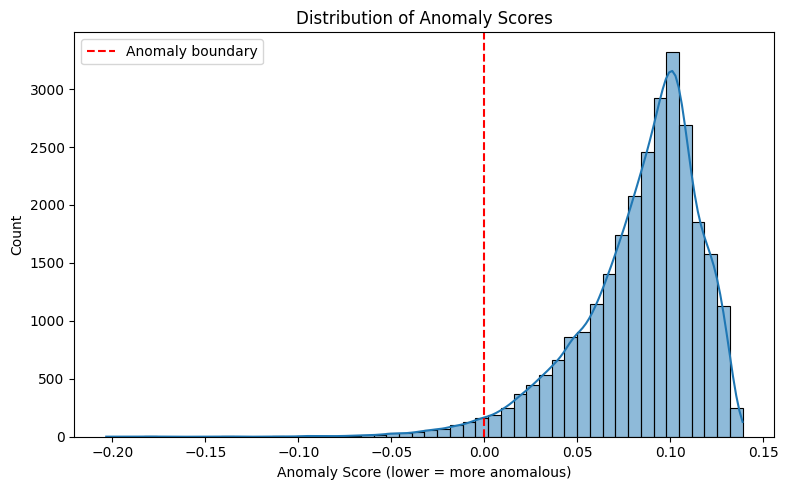

In [124]:
plt.figure(figsize=(8,5))
sns.histplot(anomaly_scores,bins=50,kde=True)
plt.axvline(0,color="red",linestyle="--",label="Anomaly boundary")
plt.title("Distribution of Anomaly Scores")
plt.xlabel("Anomaly Score (lower = more anomalous)")
plt.legend()
plt.tight_layout()
plt.show()

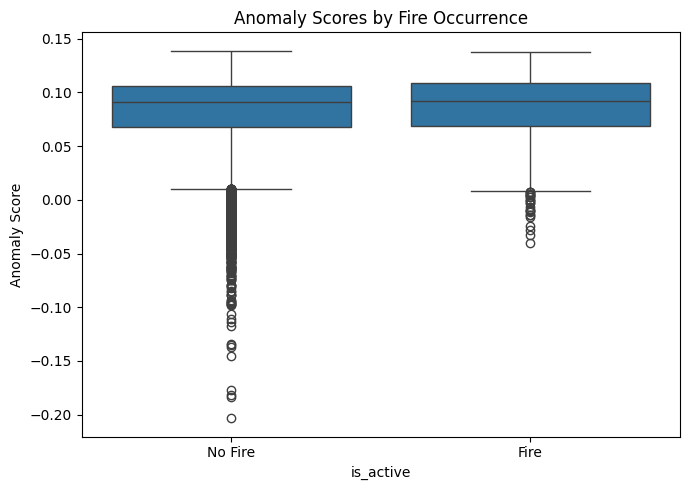

In [125]:
plt.figure(figsize=(7,5))
sns.boxplot(x=y_test_standard,y=anomaly_scores)
plt.xticks([0,1],["No Fire", "Fire"])
plt.title("Anomaly Scores by Fire Occurrence")
plt.ylabel("Anomaly Score")
plt.tight_layout()
plt.show()

c=0.002: fire=0.000%, no-fire=0.176%, precision=0.000%, recall=0.000%
c=0.005: fire=0.121%, no-fire=0.484%, precision=0.769%, recall=0.121%
c=0.01: fire=0.484%, no-fire=1.036%, precision=1.429%, recall=0.484%
c=0.02: fire=1.937%, no-fire=2.297%, precision=2.548%, recall=1.937%
c=0.03: fire=4.116%, no-fire=3.510%, precision=3.509%, recall=4.116%


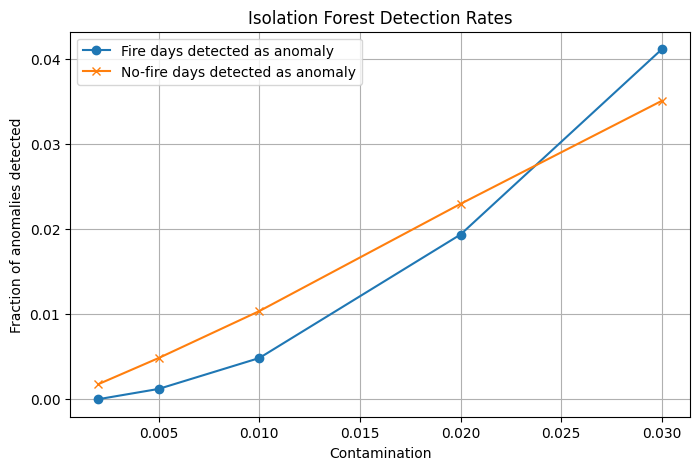

In [126]:
contaminations = [0.002, 0.005, 0.01, 0.02, 0.03]

results = []

for c in contaminations:
    iso = IsolationForest(
        n_estimators=300,
        contamination=c,
        max_samples=0.7,
        random_state=42
    )

    iso.fit(X_train_no_fire)


    scores = iso.decision_function(X_test_af)
    labels = iso.predict(X_test_af)


    labels_bin = np.where(labels == -1, 1, 0)

    fire_rate = labels_bin[y_test_standard == 1].mean()
    nofire_rate = labels_bin[y_test_standard == 0].mean()


    precision = precision_score(y_test_standard, labels_bin)
    recall = recall_score(y_test_standard, labels_bin)

    print(f"c={c}: fire={fire_rate:.3%}, no-fire={nofire_rate:.3%}, precision={precision:.3%}, recall={recall:.3%}")

    results.append({
        'contamination': c,
        'fire_rate': fire_rate,
        'no_fire_rate': nofire_rate,
        'precision': precision,
        'recall': recall
    })


fire_rates = [r['fire_rate'] for r in results]
no_fire_rates = [r['no_fire_rate'] for r in results]

plt.figure(figsize=(8,5))
plt.plot(contaminations, fire_rates, marker='o', label='Fire days detected as anomaly')
plt.plot(contaminations, no_fire_rates, marker='x', label='No-fire days detected as anomaly')
plt.xlabel('Contamination')
plt.ylabel('Fraction of anomalies detected')
plt.title('Isolation Forest Detection Rates')
plt.legend()
plt.grid(True)
plt.show()

In [137]:
X_normal=X_train_no_fire.sample(30000,random_state=42)
y_normal=np.zeros(30000)

oc_svm = OneClassSVM(kernel='rbf', gamma=0.2, nu=0.35)
oc_svm.fit(X_normal,y_normal)


labels = oc_svm.predict(X_test_af)
labels_bin = np.where(labels == -1, 1, 0)

fire_rate = labels_bin[y_test_standard == 1].mean()
nofire_rate = labels_bin[y_test_standard == 0].mean()

svm_scores = oc_svm.decision_function(X_test_af)
precision = precision_score(y_test_standard, labels_bin)
recall = recall_score(y_test_standard, labels_bin)

In [138]:
print(f"Fire days detected as anomaly: {fire_rate:.3%}")
print(f"No-fire days detected as anomaly: {nofire_rate:.3%}")
print(f"Precision: {precision:.3%}, Recall: {recall:.3%}")

Fire days detected as anomaly: 58.717%
No-fire days detected as anomaly: 67.571%
Precision: 2.624%, Recall: 58.717%


In [164]:
threshold = np.percentile(svm_scores,80)
y_pred = np.where(scores < threshold, 1, 0)

One-Class SVM learns the pattern of normal (no-fire) conditions and assigns an anomaly score to each day. Since fire events are rare and extreme, they are expected to appear in the tail of the score distribution. Therefore, a **percentile-based threshold was used to control** the sensitivity of anomaly detection. This allows prioritizing fire detection while explicitly managing the trade-off between detecting fires and raising false alarms.

In [165]:
fire_ratio = y_pred.mean() * 100
no_fire_ratio = (1 - y_pred).mean() * 100

print(f"Detected Fire days: {fire_ratio:.2f}%")
print(f"Detected No-Fire days: {no_fire_ratio:.2f}%")

Detected Fire days: 70.37%
Detected No-Fire days: 29.63%


In [166]:
print(classification_report(y_test_standard, y_pred, target_names=["No Fire", "Fire"]))

              precision    recall  f1-score   support

     No Fire       0.97      0.30      0.45     26640
        Fire       0.03      0.68      0.06       826

    accuracy                           0.31     27466
   macro avg       0.50      0.49      0.25     27466
weighted avg       0.94      0.31      0.44     27466



By adjusting the anomaly threshold, we control the sensitivity of wildfire detection. Lower thresholds reduce false alarms, while higher thresholds improve fire recall. A balanced threshold was selected to maintain high fire detection while limiting unnecessary alerts.

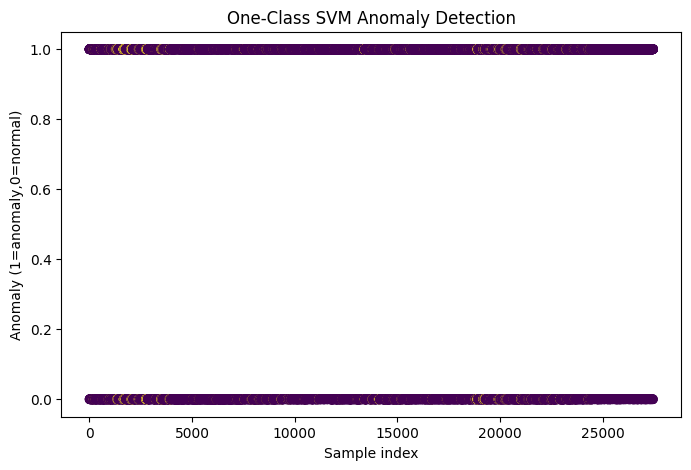

In [167]:
plt.figure(figsize=(8,5))
plt.scatter(range(len(labels_bin)), labels_bin, c=y_test_standard, label='Fire days')
plt.xlabel('Sample index')
plt.ylabel('Anomaly (1=anomaly,0=normal)')
plt.title('One-Class SVM Anomaly Detection')
plt.show()

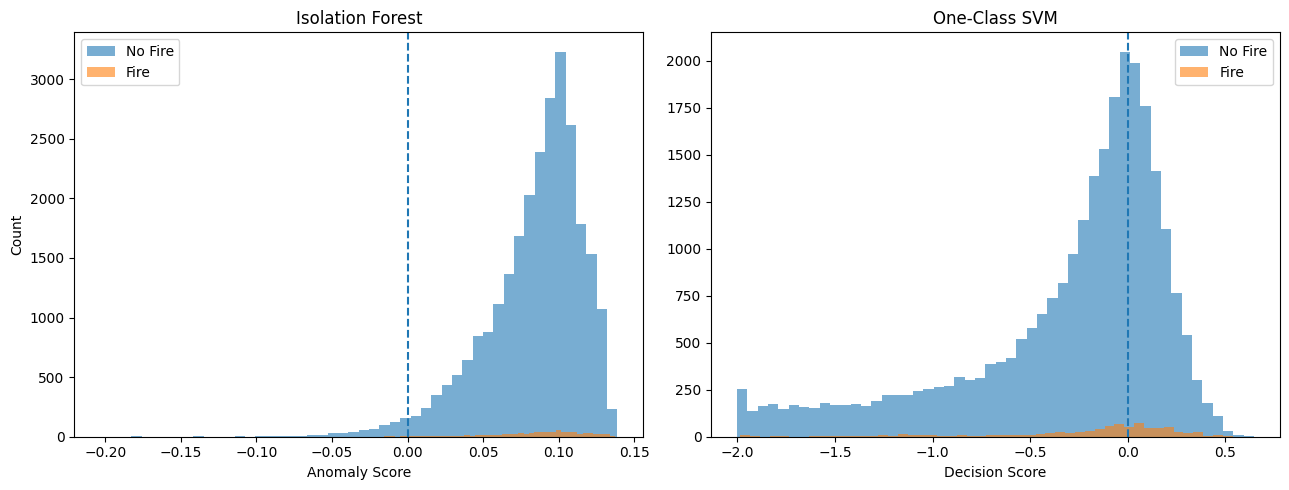

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(13,5))

axes[0].hist(anomaly_scores[y_test_standard == 0], bins=50, alpha=0.6, label="No Fire")
axes[0].hist(anomaly_scores[y_test_standard == 1], bins=50, alpha=0.6, label="Fire")
axes[0].axvline(0, linestyle="--")
axes[0].set_title("Isolation Forest")
axes[0].set_xlabel("Anomaly Score")
axes[0].set_ylabel("Count")
axes[0].legend()

axes[1].hist(svm_scores[y_test_standard == 0], bins=50, alpha=0.6, label="No Fire")
axes[1].hist(svm_scores[y_test_standard == 1], bins=50, alpha=0.6, label="Fire")
axes[1].axvline(0, linestyle="--")
axes[1].set_title("One-Class SVM")
axes[1].set_xlabel("Decision Score")
axes[1].legend()

plt.tight_layout()
plt.show()

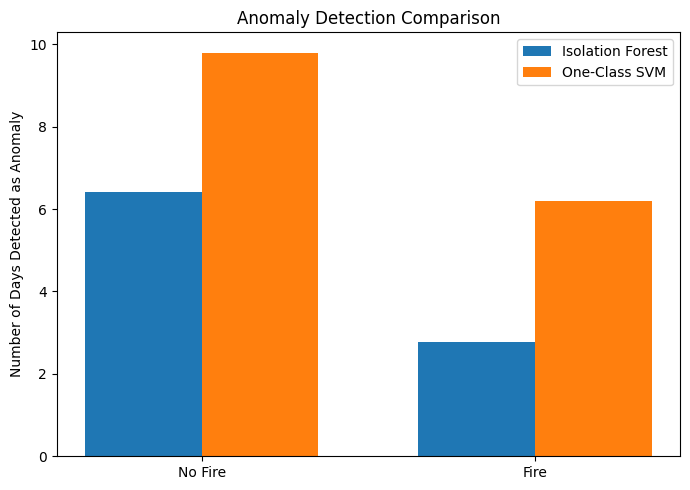

In [169]:
iso_anomaly = (anomaly_scores < 0)

iso_fire = iso_anomaly[y_test_standard == 1].sum()
iso_nofire = iso_anomaly[y_test_standard == 0].sum()


svm_scores = oc_svm.decision_function(X_test_af)
svm_anomaly = (svm_scores < 0)

svm_fire = svm_anomaly[y_test_standard == 1].sum()
svm_nofire = svm_anomaly[y_test_standard == 0].sum()

labels = ["No Fire", "Fire"]
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(7,5))

ax.bar(x - width/2, np.log([iso_nofire, iso_fire]), width, label="Isolation Forest")
ax.bar(x + width/2,np.log( [svm_nofire, svm_fire]), width, label="One-Class SVM")

ax.set_ylabel("Number of Days Detected as Anomaly")
ax.set_title("Anomaly Detection Comparison")
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

plt.tight_layout()
plt.show()

The bar plot compares the number of fire and no-fire days detected as anomalies by Isolation Forest and One-Class SVM. Both models detect a larger number of anomalies during no-fire days, indicating that wildfire events are not consistently associated with extreme anomalous conditions.

**Conclusion:**

To complement supervised models, anomaly detection methods were **applied to identify fire days** as deviations from normal environmental conditions.

> Isolation Forest demonstrated stronger performance in identifying fire days as anomalies. By isolating rare and extreme observations through random partitioning, it captured unusual combinations of weather conditions more effectively. As a result, a higher proportion of fire days were detected as anomalies compared to no-fire days, making Isolation Forest more suitable for wildfire risk screening.


> One-Class SVM was trained using predominantly no-fire days to learn the normal behavior of weather and environmental features. By tuning the anomaly threshold, the model was able to increase sensitivity to extreme conditions associated with fires. However, the overlap between fire and non-fire feature distributions limited its ability to clearly separate the two classes.



**Overall, anomaly detection proved valuable as a risk-based early warning approach, highlighting days with unusual environmental conditions even when direct fire prediction is challenging.**


So, yes anomaly detection techniques can partially identify rare or extreme environmental conditions associated with wildfire events, but with important limitations.

Both One-Class SVM and Isolation Forest were able to flag a higher proportion of fire days as anomalous compared to normal days, indicating that wildfire events tend to occur under unusual or extreme combinations of weather conditions. Among the tested methods, Isolation Forest showed stronger capability in separating fire-related anomalies from normal conditions.

However, a substantial overlap between fire and no-fire conditions was observed, limiting the precision of anomaly detection. This suggests that while fires are associated with extreme conditions, many non-fire days may exhibit similar environmental patterns, making perfect separation infeasible.
anomaly detection is effective as a risk-screening and early-warning tool, highlighting potentially dangerous conditions rather than providing definitive fire predictions.

>***Anomaly detection identifies risk conditions, not certainty of wildfire occurrence.***